# **Stock Price Prediction and GameStop Short Squeeze**

In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import yfinance as yf
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime as dt
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

import re
import string

from tqdm.auto import tqdm


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
!pip install torchmetrics -q
!pip install torchsummaryX -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.7 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
from torchsummaryX import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Stock data loading...**

In [82]:
stocks = yf.download(tickers = 'GME', start = '2021-1-1',end = '2021-8-31')
print('\nThe shape is:',stocks.shape)
stocks.tail(10)

[*********************100%%**********************]  1 of 1 completed


The shape is: (166, 6)


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2021-08-17  40.297501  42.369999  40.275002  40.887501  40.887501   4863600
2021-08-18  40.812500  41.400002  39.187500  39.262501  39.262501   5647200
2021-08-19  39.192501  39.497501  37.695000  38.224998  38.224998   4786000
2021-08-20  38.450001  40.022499  38.310001  39.825001  39.825001   4619600
2021-08-23  40.595001  41.822498  39.887501  41.222500  41.222500   5372000
2021-08-24  41.572498  56.250000  41.287498  52.572498  52.572498  58608800
2021-08-25  51.662498  56.750000  48.250000  49.912498  49.912498  51444400
2021-08-26  50.169998  54.250000  49.750000  51.305000  51.305000  24954400
2021-08-27  51.924999  53.250000  50.005001  51.237499  51.237499  12923200
2021-08-30  51.250000  54.547501  50.755001  52.299999  52.299999  13238400

In [83]:
stocks.head(10)

Open     High     Low   Close  Adj Close     Volume
Date                                                             
2021-01-04  4.7500   4.7750  4.2875  4.3125     4.3125   40090000
2021-01-05  4.3375   4.5200  4.3075  4.3425     4.3425   19846000
2021-01-06  4.3350   4.7450  4.3325  4.5900     4.5900   24224800
2021-01-07  4.6175   4.8625  4.5050  4.5200     4.5200   24517200
2021-01-08  4.5450   4.5750  4.2700  4.4225     4.4225   25928000
2021-01-11  4.8525   5.1625  4.7525  4.9850     4.9850   59632000
2021-01-12  4.9900   5.1000  4.8300  4.9875     4.9875   28242800
2021-01-13  5.1050   9.6625  5.0075  7.8500     7.8500  578006800
2021-01-14  9.5225  10.7650  8.2625  9.9775     9.9775  374869600
2021-01-15  9.6225  10.1875  8.5025  8.8750     8.8750  187465600

In [84]:
stocks.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### **filling the missing dates**

In [85]:
stocks = stocks.reindex(pd.date_range('2021-01-01', '2021-08-31'), fill_value= np.NaN)
stocks.head()

Open   High     Low   Close  Adj Close      Volume
2021-01-01     NaN    NaN     NaN     NaN        NaN         NaN
2021-01-02     NaN    NaN     NaN     NaN        NaN         NaN
2021-01-03     NaN    NaN     NaN     NaN        NaN         NaN
2021-01-04  4.7500  4.775  4.2875  4.3125     4.3125  40090000.0
2021-01-05  4.3375  4.520  4.3075  4.3425     4.3425  19846000.0

In [86]:
stocks['Open']=stocks['Open'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
stocks['High']=stocks['High'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
stocks['Low']=stocks['Low'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
stocks['Close']=stocks['Close'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
stocks['Adj Close']=stocks['Adj Close'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
stocks['Volume']=stocks['Volume'].interpolate(method='spline', order=1, limit=10, limit_direction='both')

In [87]:
print(stocks.shape)
stocks.head()

(243, 6)


Open      High       Low     Close  Adj Close        Volume
2021-01-01  4.444938  3.783135  2.574162  2.803689   2.803689  1.008220e+08
2021-01-02  4.462873  3.975103  2.897751  3.142336   3.142336  8.057800e+07
2021-01-03  4.480808  4.167070  3.221340  3.480984   3.480984  6.033400e+07
2021-01-04  4.750000  4.775000  4.287500  4.312500   4.312500  4.009000e+07
2021-01-05  4.337500  4.520000  4.307500  4.342500   4.342500  1.984600e+07

In [88]:
# move Clost to the first column
# Assuming 'data' is your original DataFrame
columns = stocks.columns.tolist()  # Get a list of all the column names
columns.insert(0, columns.pop(columns.index('Close')))  # Move 'Close' to the first position

# Reindex the DataFrame with the new column order
stocks = stocks[columns]
stocks.head()

Close      Open      High       Low  Adj Close        Volume
2021-01-01  2.803689  4.444938  3.783135  2.574162   2.803689  1.008220e+08
2021-01-02  3.142336  4.462873  3.975103  2.897751   3.142336  8.057800e+07
2021-01-03  3.480984  4.480808  4.167070  3.221340   3.480984  6.033400e+07
2021-01-04  4.312500  4.750000  4.775000  4.287500   4.312500  4.009000e+07
2021-01-05  4.342500  4.337500  4.520000  4.307500   4.342500  1.984600e+07

In [89]:
stocks.reset_index(inplace=True)
stocks.rename(columns={'index': 'date'}, inplace=True)  # Only necessary if your index didn't have a name.
stocks.head()

date     Close      Open      High       Low  Adj Close        Volume
0 2021-01-01  2.803689  4.444938  3.783135  2.574162   2.803689  1.008220e+08
1 2021-01-02  3.142336  4.462873  3.975103  2.897751   3.142336  8.057800e+07
2 2021-01-03  3.480984  4.480808  4.167070  3.221340   3.480984  6.033400e+07
3 2021-01-04  4.312500  4.750000  4.775000  4.287500   4.312500  4.009000e+07
4 2021-01-05  4.342500  4.337500  4.520000  4.307500   4.342500  1.984600e+07

In [43]:
# save this dataframe for later quick loading
stocks.to_csv('/content/drive/MyDrive/94812/stocks.csv')

## **Reddit data loading...**

### **Reddit API**

In [28]:
# the API credentials are stored in a separate file, and commited to .gitignore
# from config import reddit

In [29]:
pip install asyncpraw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 1.8 MB/s eta 0:00:00


In [30]:
import asyncpraw
import pandas as pd
import datetime as dt

reddit=asyncpraw.Reddit(
    client_id="V0EZVJDBMfGljAzVGnmhtw",
    client_secret="x6ZKxU1imqFrvPbtk27ROnNfr2DNMw",
    password="YJYangela1137!",
    user_agent="94812 homework",
    username="valerieyuan",
)

In [31]:
# Define the subreddits and search queries
subreddits = ['wallstreetbets', 'gamestopstock', 'stocks','stockmarket','gme','superstonk','ddintogme','gmejungle']
queries = ['gme', 'gamestop','stock','stocks']

# Define the time period
start_epoch = int(dt.datetime(2021, 1, 1).timestamp())
end_epoch = int(dt.datetime(2021, 12, 31).timestamp())

df_reddit = []

# Search for submissions in the defined time period across subreddits and queries
for subreddit_name in subreddits:
    subreddit = await reddit.subreddit(subreddit_name)
    for query in queries:
        async for submission in subreddit.search(query, sort='old', time_filter='all'):
            t = submission.created_utc
            if start_epoch <= int(t) <= end_epoch:
                title = submission.title
                body = submission.selftext
                post_date = dt.datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')
                df_reddit.append([post_date, title, body, subreddit_name])

# Remove duplicates and convert to DataFrame
df_reddit = pd.DataFrame(list(set(tuple(i) for i in df_reddit)), columns=['date', 'title', 'body', 'subreddit'])
df_reddit = df_reddit.sort_values('date').reset_index(drop=True)

df_reddit

date                                              title  \
0     2021-01-10 11:50:16                                          NIO Stock   
1     2021-01-10 15:46:00                                Clean Energy Stocks   
2     2021-01-11 12:34:40  GameStop Announces Additional Board Refreshmen...   
3     2021-01-11 18:49:47     Why is GameStop (GME) doing so well this year?   
4     2021-01-12 18:49:02  Please do something about these "Recommend me ...   
...                   ...                                                ...   
1487  2021-12-29 14:46:28                        My stocks over the holidays   
1488  2021-12-29 15:59:15  GAMESTOP CHANGED THE GAME: ADDED CODE TO THE R...   
1489  2021-12-29 20:05:46               Albert Einstein of the stock markets   
1490  2021-12-29 21:56:05  How much more evidence do we really need to se...   
1491  2021-12-30 10:34:48  What are the most likely catalysts to push up ...   

                                                   body       subreddit  
0     This NIO stock really seems like an amazing in...     stockmarket  
1     What are some individual stocks or ETF’s you c...     stockmarket  
2                                                        wallstreetbets  
3     Over the past year, GME is up 270% and just ov...          stocks  
4     There are probably 3-5 posts per day from user...          stocks  
...                                                 ...             ...  
1487                                                     wallstreetbets  
1488  So I came across [this](https://www.reddit.com...      superstonk  
1489                                                     wallstreetbets  
1490                                                                gme  
1491                                                      gamestopstock  

[1492 rows x 4 columns]

In [32]:
api_reddit = df_reddit.copy()
api_reddit.isnull().sum()

date         0
title        0
body         0
subreddit    0
dtype: int64

In [33]:
# Convert date to the desired format (yyyy-mm-dd)
api_reddit['date'] = pd.to_datetime(api_reddit['date']).dt.date

# Calculate the text length distribution of title and body
api_reddit['title_length'] = api_reddit['title'].str.len()
api_reddit['body_length'] = api_reddit['body'].str.len()

In [34]:
# Count the number of empty strings in title and body
empty_title_count = (api_reddit['title'] == '').sum()
empty_body_count = (api_reddit['body'] == '').sum()

In [35]:
# Display the updated DataFrame and empty string counts
empty_title_count, empty_body_count

(0, 694)

In [36]:
api_reddit.head()

date                                              title  \
0  2021-01-10                                          NIO Stock   
1  2021-01-10                                Clean Energy Stocks   
2  2021-01-11  GameStop Announces Additional Board Refreshmen...   
3  2021-01-11     Why is GameStop (GME) doing so well this year?   
4  2021-01-12  Please do something about these "Recommend me ...   

                                                body       subreddit  \
0  This NIO stock really seems like an amazing in...     stockmarket   
1  What are some individual stocks or ETF’s you c...     stockmarket   
2                                                     wallstreetbets   
3  Over the past year, GME is up 270% and just ov...          stocks   
4  There are probably 3-5 posts per day from user...          stocks   

   title_length  body_length  
0             9          322  
1            19          179  
2            76            0  
3            46          440  
4            85          815

56.9269436997319
47.0
300
3


<Axes: >

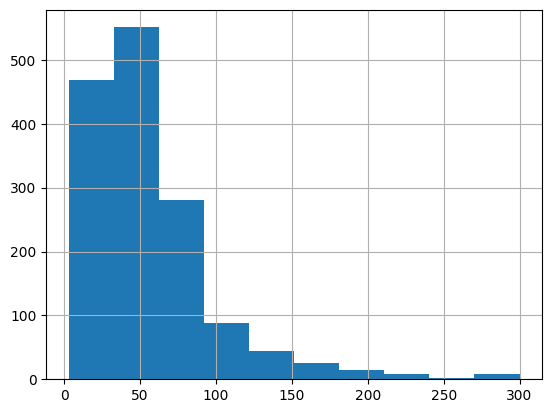

In [37]:
print(api_reddit['title_length'].mean())
print(api_reddit['title_length'].median())
print(api_reddit['title_length'].max())
print(api_reddit['title_length'].min())
api_reddit['title_length'].hist()

In [38]:
#just keep column data, title for later use
api_reddit = api_reddit[['date','title']]

### **Dataset from Harvard Dataverse**

In [39]:
import pandas as pd
gme_reddit = pd.read_csv("/content/drive/MyDrive/94812/rGME_dataset_features.csv")
gme_reddit.head()

<ipython-input-39-0dc8f787a1ba>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  gme_reddit = pd.read_csv("/content/drive/MyDrive/94812/rGME_dataset_features.csv")


Unnamed: 0      id                                              title  \
0           0  kqfajb              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀   
1           1  kqjh2t                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀   
2           2  kqvp7l  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...   
3           3  krcwch  You already know what we must do brothers and ...   
4           4  krnthg                          ICR conference (11th Jan)   

                                                 url  score            author  \
0  https://www.reddit.com/r/GME/comments/kqfajb/y...    1.0      TitsDownOnly   
1  /r/wallstreetbets/comments/kqcwdo/gamestops_gr...    1.0       zoomermoney   
2  https://www.reddit.com/r/GME/comments/kqvp7l/t...    1.0      TitsDownOnly   
3  /r/wallstreetbets/comments/kr98ym/gme_gang_we_...    1.0  dontforgettolive   
4  https://www.reddit.com/r/GME/comments/krnthg/i...    1.0           nicky94   

   num_comments        date flair  compound  ...  _poss  _intj  _appos  \
0           9.0  2021-01-04   NaN    0.9872  ...      0      0       6   
1           1.0  2021-01-04   NaN    0.9906  ...      0      0       3   
2           6.0  2021-01-05   NaN    0.5319  ...      0      0       0   
3           4.0  2021-01-05   NaN   -0.2960  ...      1      0       0   
4          10.0  2021-01-06   NaN    0.0000  ...      0      0       0   

  _npadvmod _predet  _case  _expl  _oprd  _dative _nmod  
0         0       0      0      0      0        0     0  
1         0       0      0      0      0        0     0  
2         0       0      0      0      0        0     0  
3         0       0      0      0      0        0     0  
4         1       0      0      0      0        0     0  

[5 rows x 74 columns]

In [40]:
print(gme_reddit.shape)

(1033236, 74)


In [41]:
print(gme_reddit.date.min())
print(gme_reddit.date.max())

2021-01-04
2021-12-31


In [42]:
gme_reddit = gme_reddit[['date','title']]
gme_reddit.head()

date                                              title
0  2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀
1  2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀
2  2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...
3  2021-01-05  You already know what we must do brothers and ...
4  2021-01-06                          ICR conference (11th Jan)

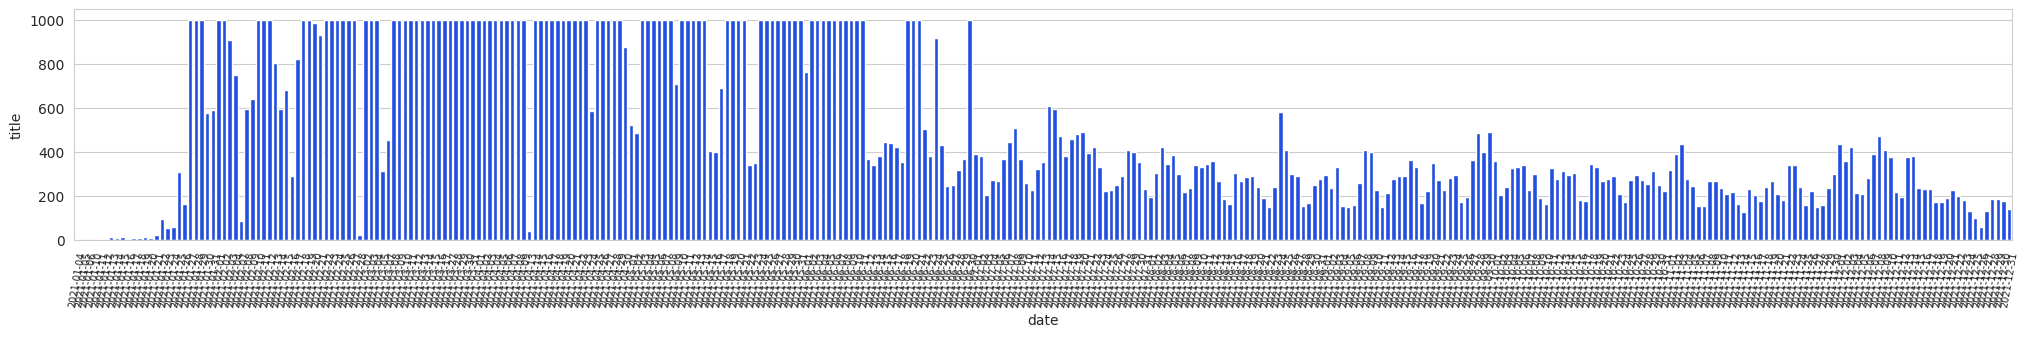

In [43]:
data=gme_reddit.copy()
data['date']=pd.to_datetime(data['date'])

plt.figure(figsize=(25,3))
sns.set_style("whitegrid")
sns.set_palette("bright")
df_count = data.groupby('date').count().reset_index()
df_count['title']=df_count['title'].clip(0,1000)
sns.barplot(df_count, x='date', y='title')
plt.xticks(rotation=80, fontsize=7)
plt.show()

### **Integration and cleaning**

concatenate gme_reddit and api_reddit

In [44]:
gme_reddit['date']=pd.to_datetime(gme_reddit['date'])
api_reddit['date']=pd.to_datetime(api_reddit['date'])

data = pd.concat([api_reddit, gme_reddit], ignore_index=True)

In [45]:
data.dtypes

date     datetime64[ns]
title            object
dtype: object

In [46]:
print(data.shape)

(1034728, 2)


In [47]:
data = data.dropna()
data.isnull().sum()

date     0
title    0
dtype: int64

In [48]:
data.date.value_counts().count()

359

In [49]:
# Sort by 'date' in ascending order
data = data.sort_values(by='date', ascending=True)

# Display the sorted dataframe
data.head()

date                                              title
1492 2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀
1493 2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀
1494 2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...
1495 2021-01-05  You already know what we must do brothers and ...
1496 2021-01-06                          ICR conference (11th Jan)

In [50]:
# save this dataframe for later quick loading
data.to_csv('/content/drive/MyDrive/94812/data_concatenated.csv')

#### **Text Cleaning**

In [51]:
data = pd.read_csv('/content/drive/MyDrive/94812/data_concatenated.csv')
data.head()

Unnamed: 0        date                                              title
0        1492  2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀
1        1493  2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀
2        1494  2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...
3        1495  2021-01-05  You already know what we must do brothers and ...
4        1496  2021-01-06                          ICR conference (11th Jan)

In [52]:
data = data.drop('Unnamed: 0',axis=1)
# Ensure the 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'])

cite the resources here. the function below is from the github:xxxx

In [53]:
!pip install emoji -q
import emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 3.0 MB/s eta 0:00:00


In [54]:
# function to clean all data
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make text lowercase
    text = text.lower()
    text = emoji.demojize(text, delimiters=(" ", " "))  #emojis are important, keep them
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text).strip()
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)

    return text

# Ensure all data are strings and clean the posts
data['text'] = data['title'].astype(str).apply(clean_text)

In [55]:
data.head()

date                                              title  \
0 2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀   
1 2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀   
2 2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...   
3 2021-01-05  You already know what we must do brothers and ...   
4 2021-01-06                          ICR conference (11th Jan)   

                                                text  
0  you need to see this about gme rocket rocket r...  
1  short squeeze incoming rocket rocket rocket ro...  
2  this convinced me to all in money_bag gme (ext...  
3  you already know what we must do brothers and ...  
4                          icr conference (11th jan)

In [56]:
# save this dataframe for later quick loading
data.to_csv('/content/drive/MyDrive/94812/data_cleaned.csv')

---

In [81]:
# save this dataframe for later quick loading
data=pd.read_csv('/content/drive/MyDrive/94812/data_cleaned.csv')
data = data.drop('Unnamed: 0',axis=1)

In [82]:
data

date                                              title  \
0        2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀   
1        2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀   
2        2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...   
3        2021-01-05  You already know what we must do brothers and ...   
4        2021-01-06                          ICR conference (11th Jan)   
...             ...                                                ...   
1034723  2021-12-31  The Great Ape Year Of The HODL ~~~ Jacked Le Tits   
1034724  2021-12-31  Hold The Line - I Am Not Fucking Selling (Dece...   
1034725  2021-12-31                                          Booked 20   
1034726  2021-12-31             Lol these shills are really everywhere   
1034727  2021-12-31                                        When GWagon   

                                                      text  
0        you need to see this about gme rocket rocket r...  
1        short squeeze incoming rocket rocket rocket ro...  
2        this convinced me to all in money_bag gme (ext...  
3        you already know what we must do brothers and ...  
4                                icr conference (11th jan)  
...                                                    ...  
1034723  the great ape year of the hodl ~~~ jacked le tits  
1034724  hold the line - i am not fucking selling (dece...  
1034725                                          booked 20  
1034726             lol these shills are really everywhere  
1034727                                        when gwagon  

[1034728 rows x 3 columns]

In [83]:
# Filter rows where the month is between January and August
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'].dt.month.between(1, 8)]

In [84]:
# Group by date and count the number of texts per day
texts_per_day_count = data.groupby(data['date'].dt.date)['text'].count()

print('The maximum number of texts on a single day is:', texts_per_day_count.max())
print('The minimum number of texts on a single day is:', texts_per_day_count.min())
print('The median number of texts on a single day is:', texts_per_day_count.median())
print('The average number of texts on a single day is:', texts_per_day_count.mean())

The maximum number of texts on a single day is: 603697
The minimum number of texts on a single day is: 1
The median number of texts on a single day is: 512.0
The average number of texts on a single day is: 4229.827004219409


The maximum number of texts on a single day is: 603697 on 2021-03-16


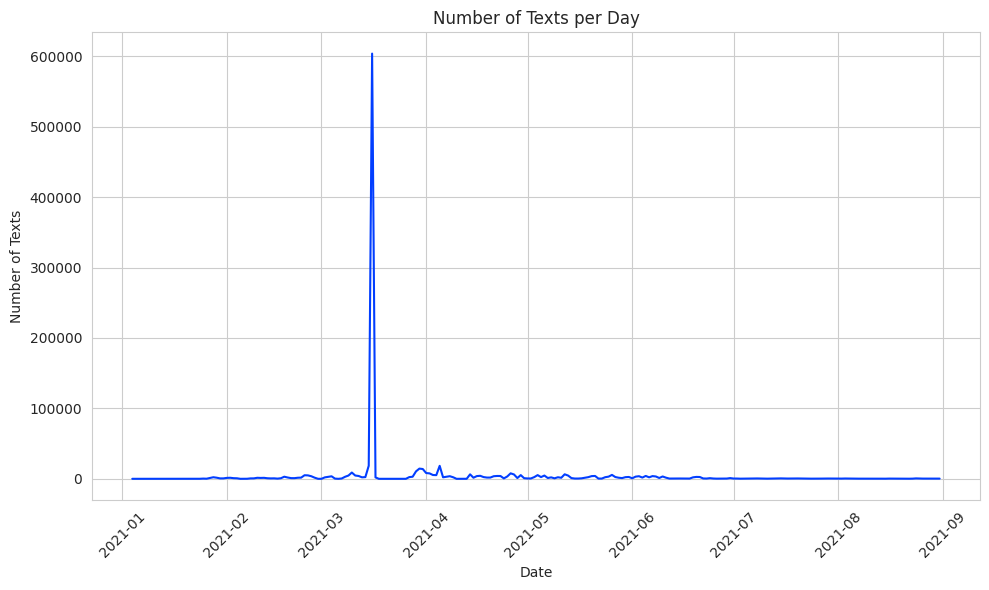

In [85]:
max_texts_count = texts_per_day_count[texts_per_day_count.idxmax()]

print(f"The maximum number of texts on a single day is: {max_texts_count} on {texts_per_day_count.idxmax()}")


# plot it
texts_per_day_count.plot(kind='line', figsize=(10, 6))

plt.title('Number of Texts per Day')
plt.xlabel('Date')
plt.ylabel('Number of Texts')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


check the number of posts per day

there are some gaps, because the api one fill the gap

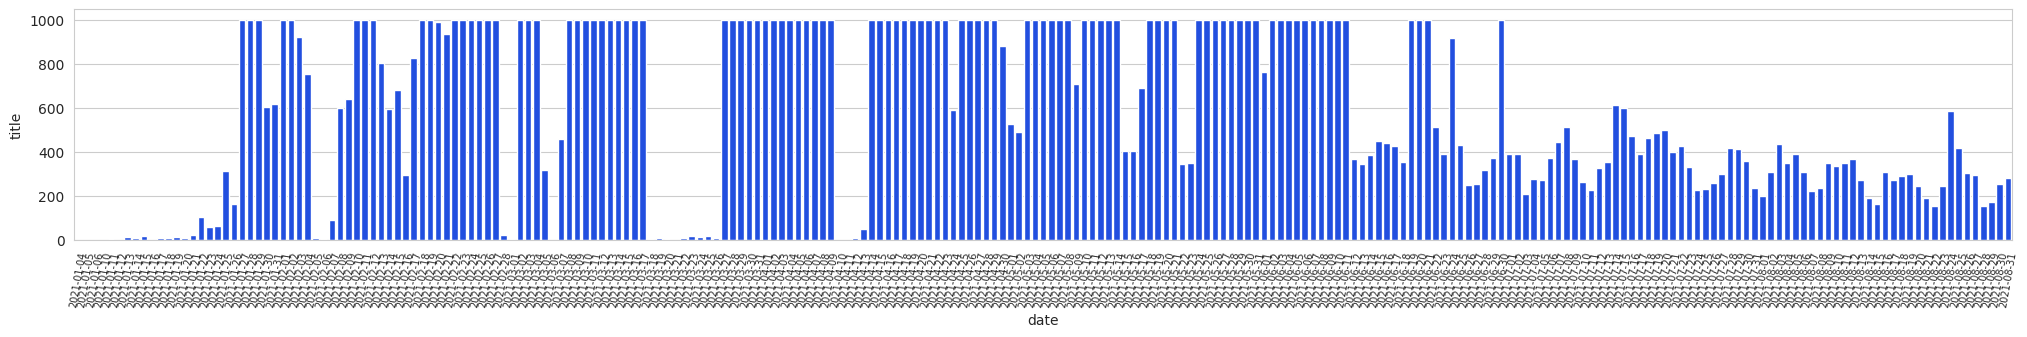

In [86]:
plt.figure(figsize=(25,3))
sns.set_style("whitegrid")
sns.set_palette("bright")
df_count = data.groupby('date').count().reset_index()
df_count['title']=df_count['title'].clip(0,1000)
sns.barplot(df_count, x='date', y='title')
plt.xticks(rotation=80, fontsize=7)
plt.show()

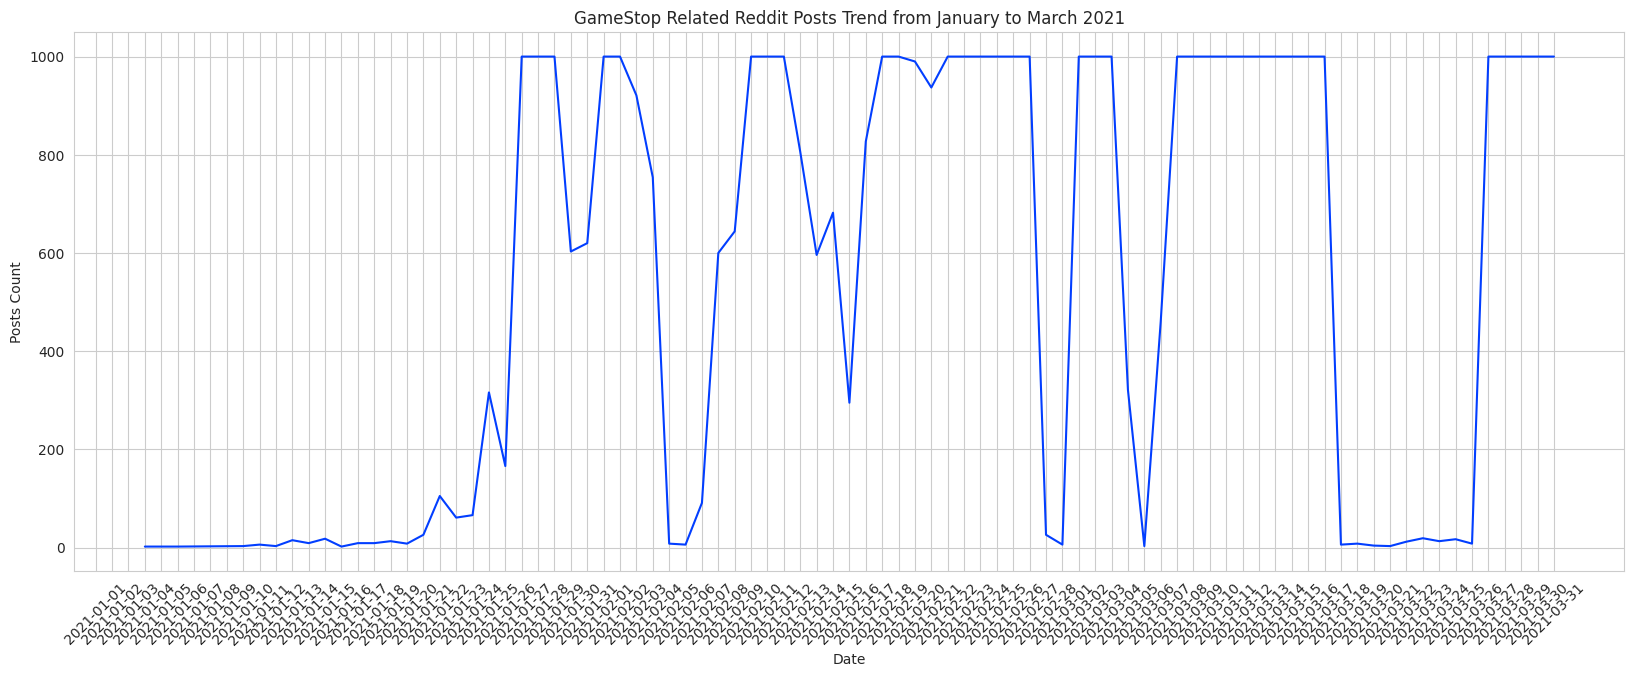

In [87]:
# Zoom to January, February and March
reddits_jtom = texts_per_day_count.to_frame(name='counts')
reddits_jtom.index = pd.to_datetime(reddits_jtom.index)

# Clip values in the 'Values' column to a maximum of 1000
reddits_jtom['Clipped_Values'] = reddits_jtom['counts'].clip(upper=1000)

# Filter the DataFrame for January 2021
reddits_jtom = reddits_jtom.loc['2021-01-01':'2021-03-31']

# Create a line plot using Seaborn
plt.figure(figsize=(20, 7))  # Set the figure size for better readability
sns.lineplot(x=reddits_jtom.index, y='Clipped_Values', data=reddits_jtom)

plt.title('GameStop Related Reddit Posts Trend from January to March 2021')
plt.xlabel('Date')
plt.ylabel('Posts Count')

# Set x-axis to show each day of January
plt.xticks(pd.date_range(start='2021-01-01', end='2021-03-31', freq='d'), rotation=45)

plt.grid(True)  # Add grid

plt.show()

randomly pick 300 posts each day

In [88]:
sampled_data= data.groupby('date').apply(lambda x: x.sample(min(len(x), 300))).reset_index(drop=True)
sampled_data

date                                              title  \
0     2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀   
1     2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀   
2     2021-01-05  You already know what we must do brothers and ...   
3     2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...   
4     2021-01-06  Hey guys! We have a free discord channel that'...   
...          ...                                                ...   
58685 2021-08-31  Eating out: I guess it is supposed to say HOLO...   
58686 2021-08-31                                    GME to the moon   
58687 2021-08-31  Is it me, or is it weird that people are posti...   
58688 2021-08-31  Hello Apes! Does anybody know why stonk-meter ...   
58689 2021-08-31  A couple of months ago I predicted that the sq...   

                                                    text  
0      short squeeze incoming rocket rocket rocket ro...  
1      you need to see this about gme rocket rocket r...  
2      you already know what we must do brothers and ...  
3      this convinced me to all in money_bag gme (ext...  
4      hey guys! we have a free discord channel that'...  
...                                                  ...  
58685  eating out: i guess it is supposed to say holo...  
58686                                    gme to the moon  
58687  is it me, or is it weird that people are posti...  
58688  hello apes! does anybody know why stonk-meter ...  
58689  a couple of months ago i predicted that the sq...  

[58690 rows x 3 columns]

In [89]:
type(sampled_data['text'][0])

str

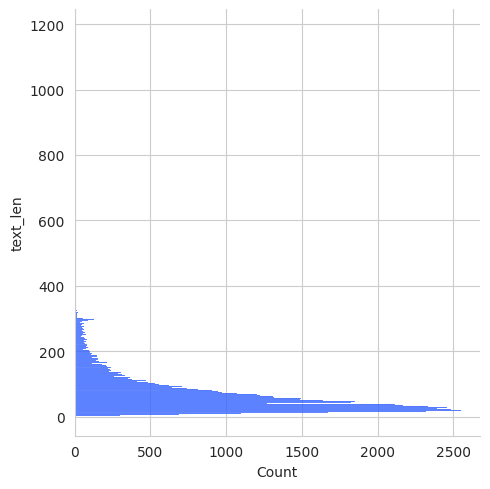

In [90]:
# Convert all non-string entries to strings
sampled_data['text'] = sampled_data['text'].astype(str)
sampled_data['text_len'] = sampled_data['text'].apply(lambda x:len(x))
sns.displot(sampled_data, y='text_len')

In [91]:
print('The longest one is:', sampled_data['text_len'].max())
print('The meidan one is:', sampled_data['text_len'].median())
print('The average one is:', sampled_data['text_len'].mean())

The longest one is: 1187
The meidan one is: 47.0
The average one is: 66.04223888226274


### **Sentiment Analysis with pretrained BERT**

BERT tokenizer

In [92]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

In [93]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out

In [94]:
df_tokenized = sampled_data['text'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

load the model

In [95]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)


In [96]:
# Load the model
# model_path = '/content/drive/MyDrive/94812/bert_finetuned.pt'
# model = torch.load(model_path)
# model.eval()  # Set the model to evaluation mode
model = torch.load("/content/drive/MyDrive/94812/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 2.0192, -1.3486, -0.8481]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [97]:
import gc

In [98]:
gc.collect()
torch.cuda.empty_cache()

In [99]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index], self.token_type_ids[index], self.att_mask[index])

In [58]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 256,
    shuffle=False
)


In [101]:
# del X
gc.collect()
torch.cuda.empty_cache()

In [102]:
sentiments = []
for X in tqdm(inference_loader, "inferencing..."):

  res = model(X).cpu().detach().numpy()
  sentiments.append(res)
  del X
  gc.collect()
  torch.cuda.empty_cache()

df_sentiment = sampled_data.copy()
df_sentiment['sentiment'] = np.vstack(sentiments).argmax(1)
df_sentiment

inferencing...:   0%|          | 0/179 [00:00<?, ?it/s]

date                                              title  \
0     2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀   
1     2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀   
2     2021-01-05  You already know what we must do brothers and ...   
3     2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...   
4     2021-01-06  Hey guys! We have a free discord channel that'...   
...          ...                                                ...   
58685 2021-08-31  Eating out: I guess it is supposed to say HOLO...   
58686 2021-08-31                                    GME to the moon   
58687 2021-08-31  Is it me, or is it weird that people are posti...   
58688 2021-08-31  Hello Apes! Does anybody know why stonk-meter ...   
58689 2021-08-31  A couple of months ago I predicted that the sq...   

                                                    text  text_len  sentiment  
0      short squeeze incoming rocket rocket rocket ro...        71          0  
1      you need to see this about gme rocket rocket r...        72          0  
2      you already know what we must do brothers and ...        95          0  
3      this convinced me to all in money_bag gme (ext...        63          0  
4      hey guys! we have a free discord channel that'...        87          0  
...                                                  ...       ...        ...  
58685  eating out: i guess it is supposed to say holo...        74          0  
58686                                    gme to the moon        15          0  
58687  is it me, or is it weird that people are posti...        75          2  
58688  hello apes! does anybody know why stonk-meter ...       124          2  
58689  a couple of months ago i predicted that the sq...       110          0  

[58690 rows x 5 columns]

In [103]:
df_sentiment.sentiment.value_counts()

0    41845
2    15860
1      985
Name: sentiment, dtype: int64

In [84]:
df_sentiment['sentiment'] = df_sentiment['sentiment'].apply(lambda x: -1 if x==2 else x)
df_sentiment

date                                              title  \
0      2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀   
1      2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀   
2      2021-01-05  You already know what we must do brothers and ...   
3      2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...   
4      2021-01-06  Hey guys! We have a free discord channel that'...   
...           ...                                                ...   
58685  2021-08-31  Eating out: I guess it is supposed to say HOLO...   
58686  2021-08-31                                    GME to the moon   
58687  2021-08-31  Is it me, or is it weird that people are posti...   
58688  2021-08-31  Hello Apes! Does anybody know why stonk-meter ...   
58689  2021-08-31  A couple of months ago I predicted that the sq...   

                                                    text  text_len  sentiment  
0      short squeeze incoming rocket rocket rocket ro...        71          0  
1      you need to see this about gme rocket rocket r...        72          0  
2      you already know what we must do brothers and ...        95          0  
3      this convinced me to all in money_bag gme (ext...        63          0  
4      hey guys! we have a free discord channel that'...        87          0  
...                                                  ...       ...        ...  
58685  eating out: i guess it is supposed to say holo...        74          0  
58686                                    gme to the moon        15          0  
58687  is it me, or is it weird that people are posti...        75         -1  
58688  hello apes! does anybody know why stonk-meter ...       124         -1  
58689  a couple of months ago i predicted that the sq...       110          0  

[58690 rows x 5 columns]

In [85]:
# save this dataframe for later quick loading
df_sentiment.to_csv('/content/drive/MyDrive/94812/sampled_data_with_senti.csv')

Due to resource constraints, I limited the analysis to a daily sample of 300 posts. After processing with BERT embeddings, I found that the vast majority of the posts, 41,845 to be exact, were classified as neutral, with 15,860 deemed negative and only 985 identified as positive.

## **Models Building, Predictions, Evaluation and Comparison**

In [6]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from scipy.stats import spearmanr as spearman
def get_metrics(prediction, true_labels):
  metrics = ['MSE', 'RMSE','MAE', 'MAPE', 'Serial Corr', 'Pearson Corr(IC),']
  metrics_value = [
  MSE(prediction,true_labels),
  MSE(prediction,true_labels)**0.5,
  MAE(prediction,true_labels),
  MAPE(prediction,true_labels),
  np.corrcoef(prediction,true_labels)[0,1],
  np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1],
  ]

  return pd.DataFrame([metrics_value], columns=metrics)


### **Baseline Model - LSTM without Social Media Sentiment Data**

In [151]:
stocks = pd.read_csv('/content/drive/MyDrive/94812/stocks.csv')
stocks.drop('Unnamed: 0',axis=1,inplace =True)
stocks

date      Close       Open       High        Low  Adj Close  \
0    2021-01-01   2.803689   4.444938   3.783135   2.574162   2.803689   
1    2021-01-02   3.142336   4.462873   3.975103   2.897751   3.142336   
2    2021-01-03   3.480984   4.480808   4.167070   3.221340   3.480984   
3    2021-01-04   4.312500   4.750000   4.775000   4.287500   4.312500   
4    2021-01-05   4.342500   4.337500   4.520000   4.307500   4.342500   
..          ...        ...        ...        ...        ...        ...   
238  2021-08-27  51.237499  51.924999  53.250000  50.005001  51.237499   
239  2021-08-28  51.698558  51.182075  54.080892  50.467156  51.698558   
240  2021-08-29  51.977083  51.326468  54.225570  50.570208  51.977083   
241  2021-08-30  52.299999  51.250000  54.547501  50.755001  52.299999   
242  2021-08-31  52.534134  51.615253  54.514926  50.776312  52.534134   

           Volume  
0    1.008220e+08  
1    8.057800e+07  
2    6.033400e+07  
3    4.009000e+07  
4    1.984600e+07  
..            ...  
238  1.292320e+07  
239  1.302827e+07  
240  1.313333e+07  
241  1.323840e+07  
242  1.334347e+07  

[243 rows x 7 columns]

In [152]:
# move Clost to the first column
# Assuming 'data' is your original DataFrame
columns = stocks.columns.tolist()  # Get a list of all the column names
columns.insert(0, columns.pop(columns.index('Close')))  # Move 'Close' to the first position

# Reindex the DataFrame with the new column order
stocks = stocks[columns]
stocks.head()

Close        date      Open      High       Low  Adj Close        Volume
0  2.803689  2021-01-01  4.444938  3.783135  2.574162   2.803689  1.008220e+08
1  3.142336  2021-01-02  4.462873  3.975103  2.897751   3.142336  8.057800e+07
2  3.480984  2021-01-03  4.480808  4.167070  3.221340   3.480984  6.033400e+07
3  4.312500  2021-01-04  4.750000  4.775000  4.287500   4.312500  4.009000e+07
4  4.342500  2021-01-05  4.337500  4.520000  4.307500   4.342500  1.984600e+07

In [153]:
stocks.head()

Close        date      Open      High       Low  Adj Close        Volume
0  2.803689  2021-01-01  4.444938  3.783135  2.574162   2.803689  1.008220e+08
1  3.142336  2021-01-02  4.462873  3.975103  2.897751   3.142336  8.057800e+07
2  3.480984  2021-01-03  4.480808  4.167070  3.221340   3.480984  6.033400e+07
3  4.312500  2021-01-04  4.750000  4.775000  4.287500   4.312500  4.009000e+07
4  4.342500  2021-01-05  4.337500  4.520000  4.307500   4.342500  1.984600e+07

In [154]:
stocks['date']=pd.to_datetime(stocks['date'])
stocks.index=stocks['date']
stocks = stocks.drop(columns='date')
stocks

Close       Open       High        Low  Adj Close  \
date                                                                
2021-01-01   2.803689   4.444938   3.783135   2.574162   2.803689   
2021-01-02   3.142336   4.462873   3.975103   2.897751   3.142336   
2021-01-03   3.480984   4.480808   4.167070   3.221340   3.480984   
2021-01-04   4.312500   4.750000   4.775000   4.287500   4.312500   
2021-01-05   4.342500   4.337500   4.520000   4.307500   4.342500   
...               ...        ...        ...        ...        ...   
2021-08-27  51.237499  51.924999  53.250000  50.005001  51.237499   
2021-08-28  51.698558  51.182075  54.080892  50.467156  51.698558   
2021-08-29  51.977083  51.326468  54.225570  50.570208  51.977083   
2021-08-30  52.299999  51.250000  54.547501  50.755001  52.299999   
2021-08-31  52.534134  51.615253  54.514926  50.776312  52.534134   

                  Volume  
date                      
2021-01-01  1.008220e+08  
2021-01-02  8.057800e+07  
2021-01-03  6.033400e+07  
2021-01-04  4.009000e+07  
2021-01-05  1.984600e+07  
...                  ...  
2021-08-27  1.292320e+07  
2021-08-28  1.302827e+07  
2021-08-29  1.313333e+07  
2021-08-30  1.323840e+07  
2021-08-31  1.334347e+07  

[243 rows x 6 columns]

In [155]:
total_len = len(stocks)

train = stocks[stocks.index<pd.to_datetime("2021-05-01")]
val   = stocks[(stocks.index < pd.to_datetime("2021-06-01")) & (stocks.index > pd.to_datetime("2021-05-01"))]
test  = stocks[(stocks.index < pd.to_datetime("2021-09-01")) & (stocks.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.49382716049382713 val_len 0.12345679012345678 test_len 0.3786008230452675


In [156]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape

Index(['Close', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object')


((120, 6), (30, 6), (92, 6))

In [157]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

In [158]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69), (64, 70), (65, 71), (66, 72), (67, 73), (68, 74), (69, 75), (70, 76), (71, 77), (72, 78), (73, 79), (74, 80), (75, 81), (76, 82), (77, 83), (78, 84), (79, 85), (80, 86), (81, 87), (82, 88), (83, 89), (84, 90), (85, 91), (86, 92), (87, 93), (88, 94), (89, 95), (90, 96), (91, 97), (92, 98), (93, 99), (94, 100), (95, 101), (96, 102), (97, 103), (98, 104), (99, 105), (100, 1

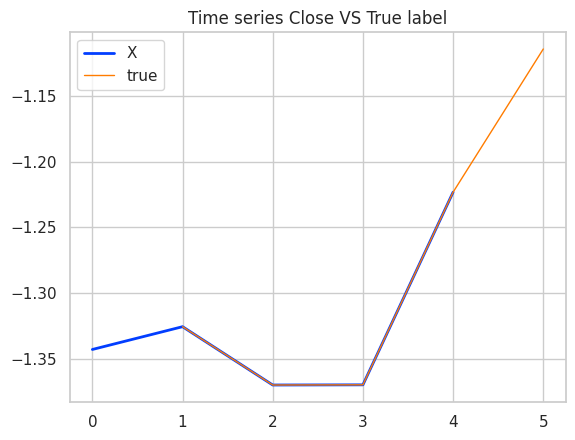

In [159]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

In [160]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [161]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([-0.9952, -1.0103, -1.0253, -0.9912, -1.0369], device='cuda:0') tensor([-1.0103, -1.0253, -0.9912, -1.0369, -1.1042], device='cuda:0')
x shape: torch.Size([64, 5, 6]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]   1.06496M  1.060864M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
---------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [162]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [163]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

In [164]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8738	 Learning Rate 0.0020000	 Validation Loss 0.2481

Epoch: 2/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5075	 Learning Rate 0.0016000	 Validation Loss 0.1353

Epoch: 3/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3368	 Learning Rate 0.0012800	 Validation Loss 0.2876

Epoch: 4/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3514	 Learning Rate 0.0010240	 Validation Loss 0.2667

Epoch: 5/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3113	 Learning Rate 0.0008192	 Validation Loss 0.1971

Epoch: 6/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2859	 Learning Rate 0.0006554	 Validation Loss 0.1353

Epoch: 7/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2241	 Learning Rate 0.0005243	 Validation Loss 0.1028

Epoch: 8/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2229	 Learning Rate 0.0004194	 Validation Loss 0.0886

Epoch: 9/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2294	 Learning Rate 0.0003355	 Validation Loss 0.0867

Epoch: 10/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2305	 Learning Rate 0.0002684	 Validation Loss 0.0914

Epoch: 11/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2248	 Learning Rate 0.0002147	 Validation Loss 0.1005

Epoch: 12/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2043	 Learning Rate 0.0001718	 Validation Loss 0.1107

Epoch: 13/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1943	 Learning Rate 0.0001374	 Validation Loss 0.1175

Epoch: 14/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1900	 Learning Rate 0.0001100	 Validation Loss 0.1217

Epoch: 15/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2076	 Learning Rate 0.0000880	 Validation Loss 0.1240

Epoch: 16/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1819	 Learning Rate 0.0000704	 Validation Loss 0.1234

Epoch: 17/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1815	 Learning Rate 0.0000563	 Validation Loss 0.1231

Epoch: 18/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1841	 Learning Rate 0.0000450	 Validation Loss 0.1221

Epoch: 19/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1936	 Learning Rate 0.0000360	 Validation Loss 0.1210

Epoch: 20/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1710	 Learning Rate 0.0000288	 Validation Loss 0.1197

Epoch: 21/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1820	 Learning Rate 0.0000231	 Validation Loss 0.1187

Epoch: 22/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1782	 Learning Rate 0.0000184	 Validation Loss 0.1179

Epoch: 23/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1692	 Learning Rate 0.0000148	 Validation Loss 0.1174

Epoch: 24/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1718	 Learning Rate 0.0000118	 Validation Loss 0.1168

Epoch: 25/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1961	 Learning Rate 0.0000094	 Validation Loss 0.1162

Epoch: 26/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1799	 Learning Rate 0.0000076	 Validation Loss 0.1158

Epoch: 27/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1802	 Learning Rate 0.0000060	 Validation Loss 0.1155

Epoch: 28/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1755	 Learning Rate 0.0000048	 Validation Loss 0.1152

Epoch: 29/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1790	 Learning Rate 0.0000039	 Validation Loss 0.1151

Epoch: 30/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1829	 Learning Rate 0.0000031	 Validation Loss 0.1149

Epoch: 31/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1715	 Learning Rate 0.0000025	 Validation Loss 0.1147

Epoch: 32/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1782	 Learning Rate 0.0000020	 Validation Loss 0.1146

Epoch: 33/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1818	 Learning Rate 0.0000016	 Validation Loss 0.1146

Epoch: 34/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1738	 Learning Rate 0.0000013	 Validation Loss 0.1145

Epoch: 35/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1802	 Learning Rate 0.0000010	 Validation Loss 0.1144

Epoch: 36/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1787	 Learning Rate 0.0000008	 Validation Loss 0.1144

Epoch: 37/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1641	 Learning Rate 0.0000006	 Validation Loss 0.1143

Epoch: 38/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1842	 Learning Rate 0.0000005	 Validation Loss 0.1143

Epoch: 39/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1692	 Learning Rate 0.0000004	 Validation Loss 0.1143

Epoch: 40/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1826	 Learning Rate 0.0000003	 Validation Loss 0.1143

Epoch: 41/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1856	 Learning Rate 0.0000003	 Validation Loss 0.1142

Epoch: 42/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1735	 Learning Rate 0.0000002	 Validation Loss 0.1142

Epoch: 43/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1858	 Learning Rate 0.0000002	 Validation Loss 0.1142

Epoch: 44/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1809	 Learning Rate 0.0000001	 Validation Loss 0.1142

Epoch: 45/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1850	 Learning Rate 0.0000001	 Validation Loss 0.1142

Epoch: 46/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1879	 Learning Rate 0.0000001	 Validation Loss 0.1142

Epoch: 47/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1802	 Learning Rate 0.0000001	 Validation Loss 0.1142

Epoch: 48/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1949	 Learning Rate 0.0000001	 Validation Loss 0.1142

Epoch: 49/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1836	 Learning Rate 0.0000000	 Validation Loss 0.1142

Epoch: 50/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1738	 Learning Rate 0.0000000	 Validation Loss 0.1142


Text(0.5, 1.0, 'Validation loss')

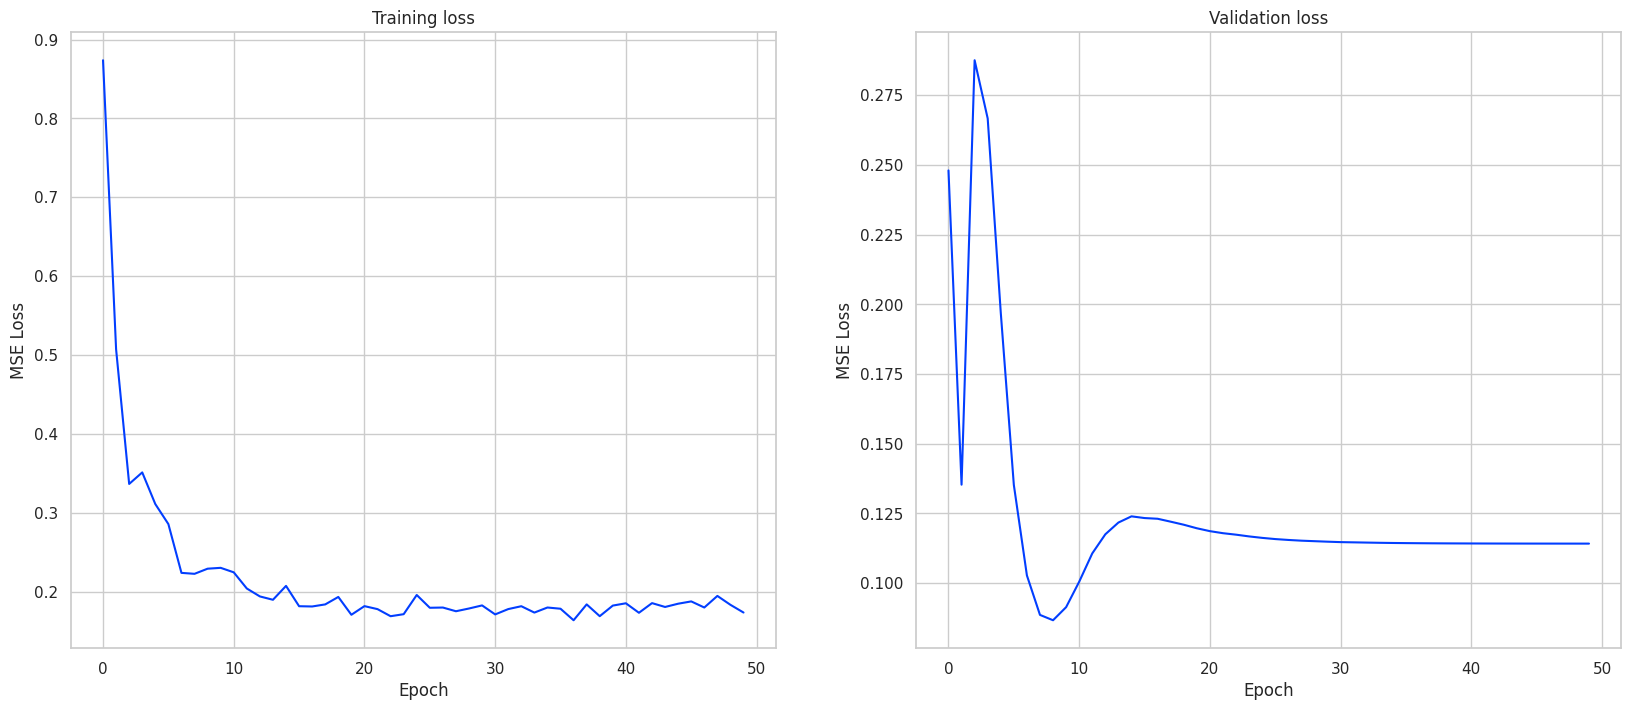

In [165]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")

In [166]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_test_metrics = get_metrics(prediction,true_labels)
metrics1 = baseline_test_metrics
metrics1

Train:   0%|          | 0/4 [00:00<?, ?it/s]

(86,) (86,)


MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),
0  42.243553  6.499504  4.629339  0.101011     0.897313          -0.155132

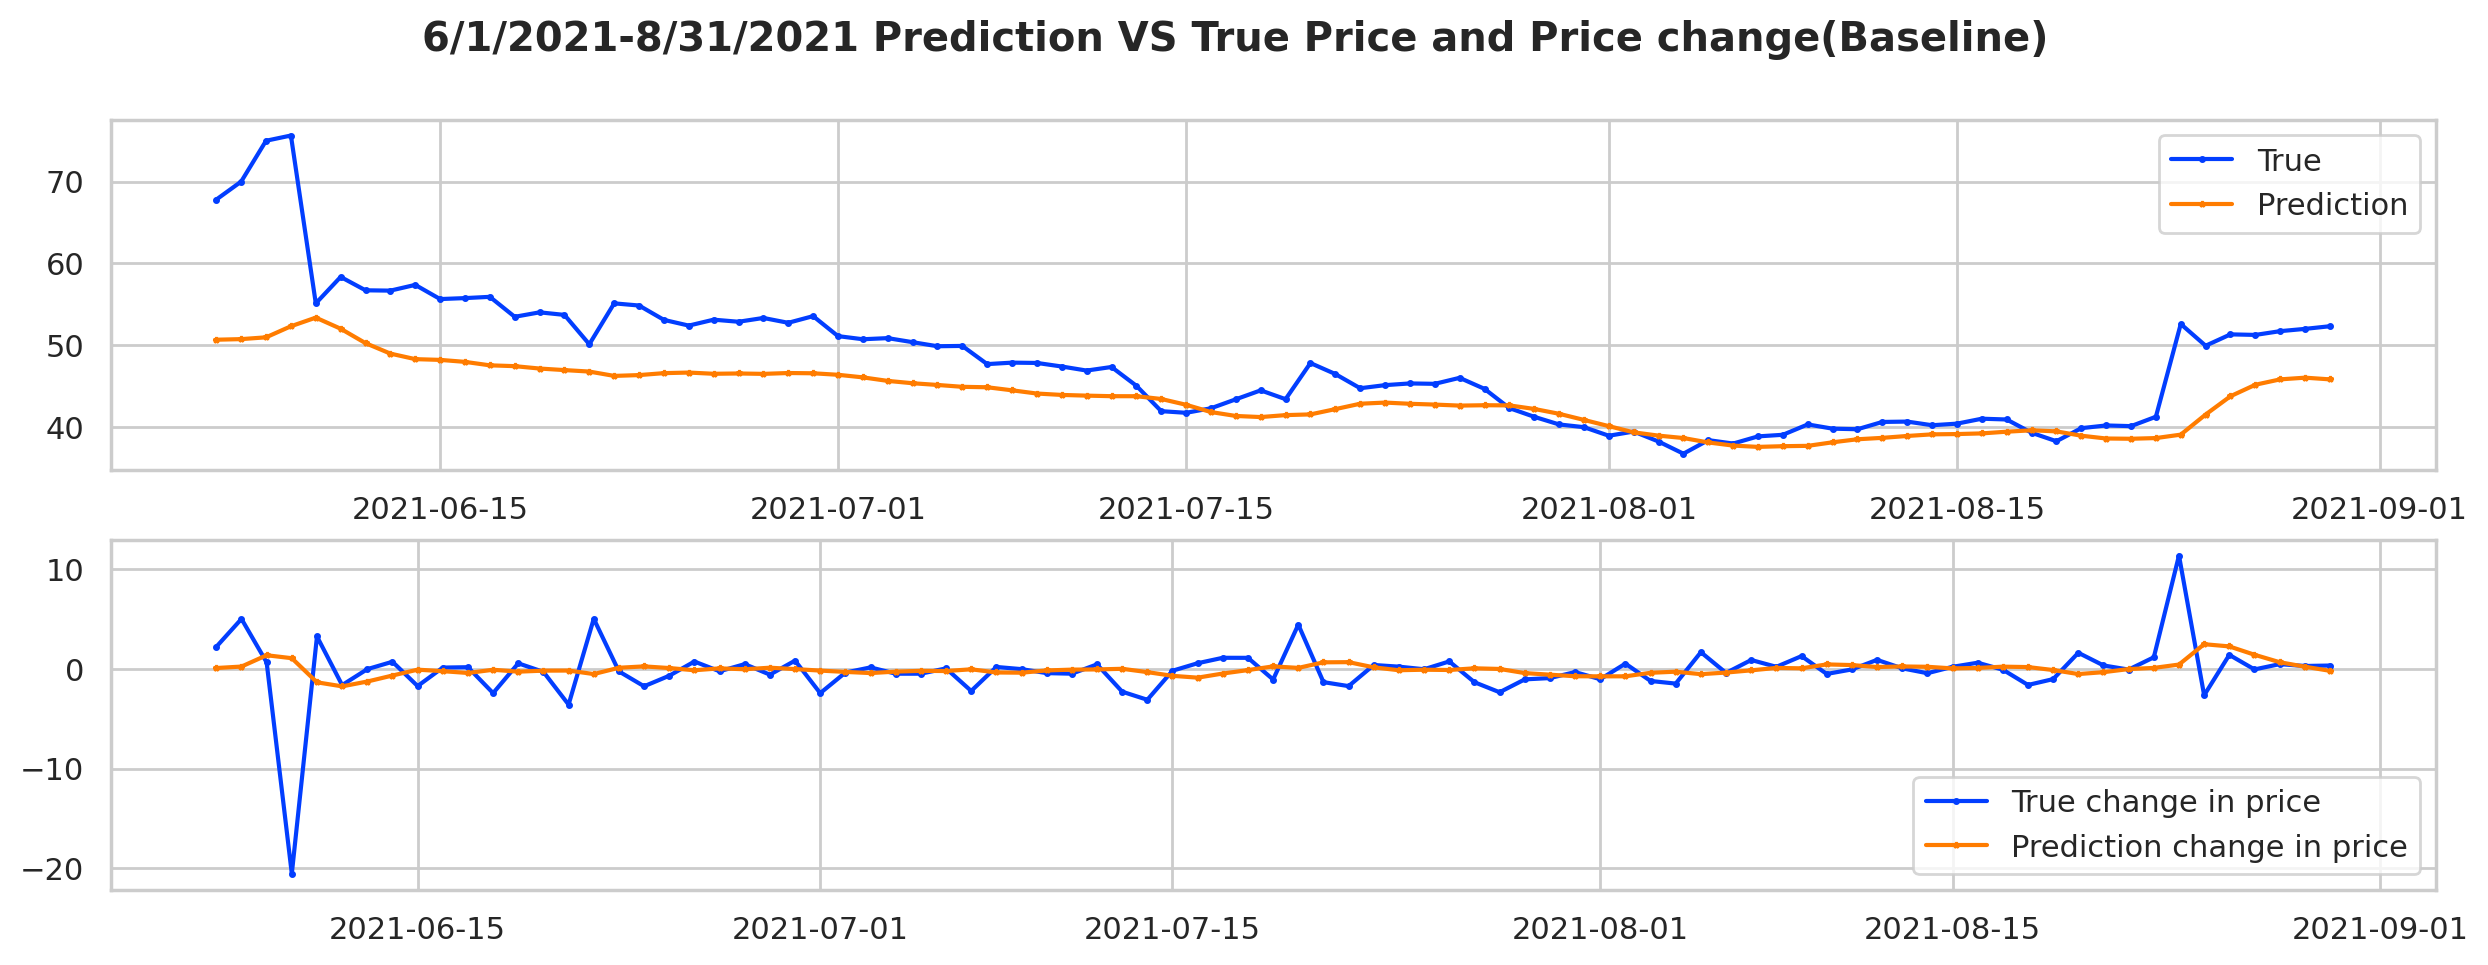

In [167]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming true_labels and prediction are numpy arrays or lists containing the true and predicted values.

# Filter the dataframe for the date range you're interested in and get the index as a datetime format
filtered_df = stocks.loc[pd.to_datetime("2021-06-06"):pd.to_datetime("2021-08-30")]
date = filtered_df.index  # This should give you the date index directly

fig, ax = plt.subplots(2, 1, figsize=(15, 5), dpi=200)
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction', marker='*', markersize=2)
ax[0].legend()

# For the difference/delta plots, make sure the arrays are the correct length
# If true_labels and prediction are one element longer than the date array after diff, you need to slice them
true_changes = np.diff(true_labels)
pred_changes = np.diff(prediction)

# Ensure the lengths of date[1:], true_changes, and pred_changes are all equal
ax[1].plot(date[1:], true_changes, label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], pred_changes, label='Prediction change in price', marker='*', markersize=2)
ax[1].legend()

fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Baseline)", fontweight="bold")
plt.show()


### **LSTM with Sentiment Label**

In [90]:
# load the data previously cleaned and stored
df_senti = pd.read_csv('/content/drive/MyDrive/94812/sampled_data_with_senti.csv')
stocks = pd.read_csv('/content/drive/MyDrive/94812/stocks.csv')

df_senti = df_senti.drop('Unnamed: 0',axis=1)
stocks = stocks.drop('Unnamed: 0',axis=1)
# Ensure the 'date' column is in datetime format
df_senti['date'] = pd.to_datetime(df_senti['date'])
stocks['date'] = pd.to_datetime(stocks['date'])

In [91]:
df_senti = df_senti.groupby('date')['sentiment'].mean().reset_index()
df_senti

date  sentiment
0   2021-01-04   0.000000
1   2021-01-05   0.000000
2   2021-01-06   0.000000
3   2021-01-10   0.000000
4   2021-01-11  -0.166667
..         ...        ...
232 2021-08-27  -0.289562
233 2021-08-28  -0.152866
234 2021-08-29  -0.196532
235 2021-08-30  -0.254902
236 2021-08-31  -0.306338

[237 rows x 2 columns]

In [92]:
df_sa = stocks.merge(df_senti, on='date', how='inner')
print(df_sa.shape)
df_sa.head()

(237, 8)


date     Close      Open      High       Low  Adj Close        Volume  \
0 2021-01-04  4.312500  4.750000  4.775000  4.287500   4.312500  4.009000e+07   
1 2021-01-05  4.342500  4.337500  4.520000  4.307500   4.342500  1.984600e+07   
2 2021-01-06  4.590000  4.335000  4.745000  4.332500   4.590000  2.422480e+07   
3 2021-01-10  5.851518  4.606354  5.510845  5.486463   5.851518  4.839733e+07   
4 2021-01-11  4.985000  4.852500  5.162500  4.752500   4.985000  5.963200e+07   

   sentiment  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4  -0.166667

In [93]:
df_sa['date'] = pd.to_datetime(df_sa['date'])
df_sa.index = df_sa['date']
df_sa=df_sa.drop(columns=['date'])
df_sa.head()

Close      Open      High       Low  Adj Close        Volume  \
date                                                                          
2021-01-04  4.312500  4.750000  4.775000  4.287500   4.312500  4.009000e+07   
2021-01-05  4.342500  4.337500  4.520000  4.307500   4.342500  1.984600e+07   
2021-01-06  4.590000  4.335000  4.745000  4.332500   4.590000  2.422480e+07   
2021-01-10  5.851518  4.606354  5.510845  5.486463   5.851518  4.839733e+07   
2021-01-11  4.985000  4.852500  5.162500  4.752500   4.985000  5.963200e+07   

            sentiment  
date                   
2021-01-04   0.000000  
2021-01-05   0.000000  
2021-01-06   0.000000  
2021-01-10   0.000000  
2021-01-11  -0.166667

#### **Correlation Analysis**

In [94]:
ca = df_sa.copy()
ca['price_change'] = ca['Close'].diff().fillna(0)
ca['sentiment_change'] = ca['sentiment'].diff().fillna(0)
ca

Close       Open       High        Low  Adj Close  \
date                                                                
2021-01-04   4.312500   4.750000   4.775000   4.287500   4.312500   
2021-01-05   4.342500   4.337500   4.520000   4.307500   4.342500   
2021-01-06   4.590000   4.335000   4.745000   4.332500   4.590000   
2021-01-10   5.851518   4.606354   5.510845   5.486463   5.851518   
2021-01-11   4.985000   4.852500   5.162500   4.752500   4.985000   
...               ...        ...        ...        ...        ...   
2021-08-27  51.237499  51.924999  53.250000  50.005001  51.237499   
2021-08-28  51.698558  51.182075  54.080892  50.467156  51.698558   
2021-08-29  51.977083  51.326468  54.225570  50.570208  51.977083   
2021-08-30  52.299999  51.250000  54.547501  50.755001  52.299999   
2021-08-31  52.534134  51.615253  54.514926  50.776312  52.534134   

                  Volume  sentiment  price_change  sentiment_change  
date                                                                 
2021-01-04  4.009000e+07   0.000000      0.000000          0.000000  
2021-01-05  1.984600e+07   0.000000      0.030000          0.000000  
2021-01-06  2.422480e+07   0.000000      0.247500          0.000000  
2021-01-10  4.839733e+07   0.000000      1.261518          0.000000  
2021-01-11  5.963200e+07  -0.166667     -0.866518         -0.166667  
...                  ...        ...           ...               ...  
2021-08-27  1.292320e+07  -0.289562     -0.067501         -0.016229  
2021-08-28  1.302827e+07  -0.152866      0.461058          0.136696  
2021-08-29  1.313333e+07  -0.196532      0.278525         -0.043666  
2021-08-30  1.323840e+07  -0.254902      0.322916         -0.058370  
2021-08-31  1.334347e+07  -0.306338      0.234134         -0.051436  

[237 rows x 9 columns]

<Axes: xlabel='date', ylabel='price_change'>

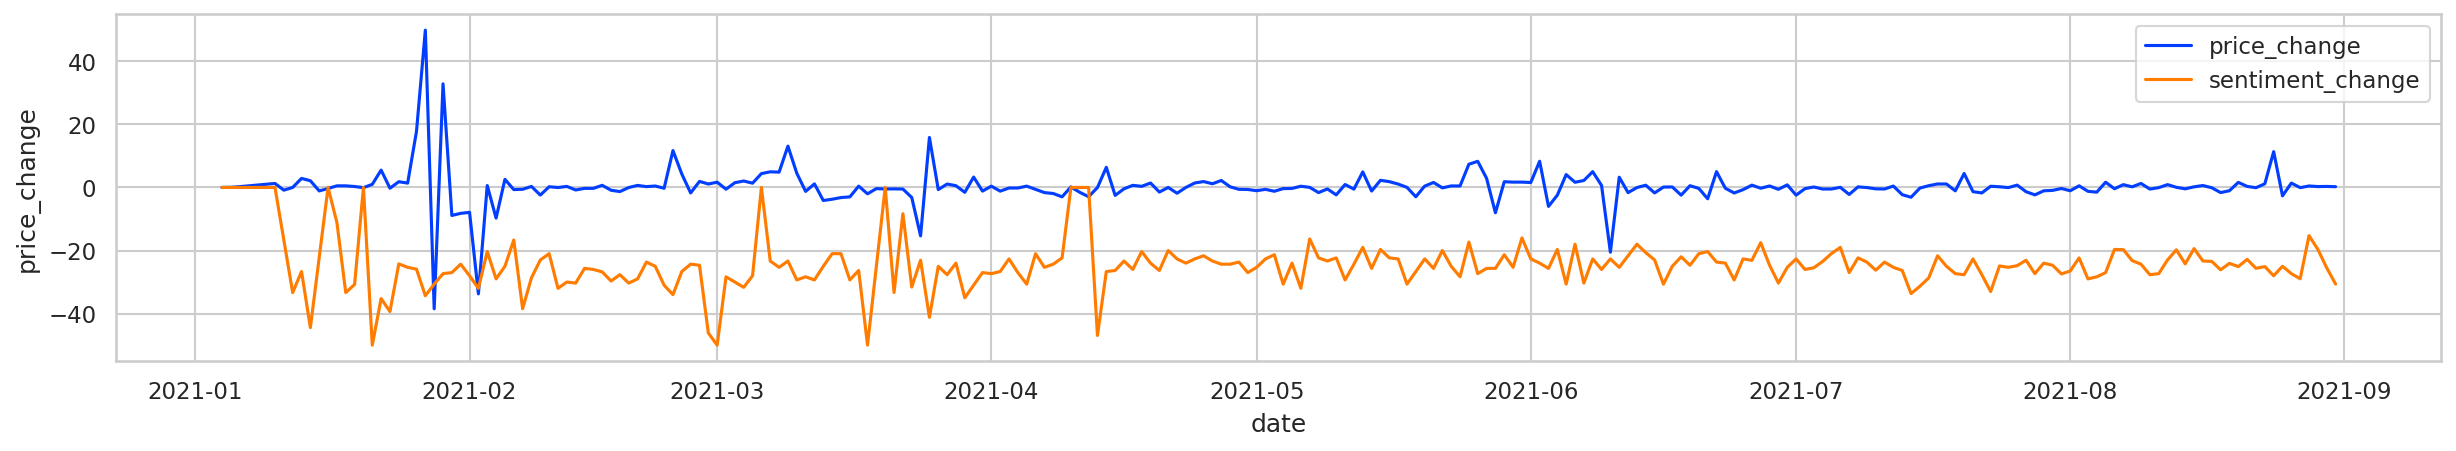

In [95]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(ca['price_change'], label ='price_change')
sns.lineplot(ca['sentiment']*100, label = 'sentiment_change')

<Axes: xlabel='date', ylabel='price_change'>

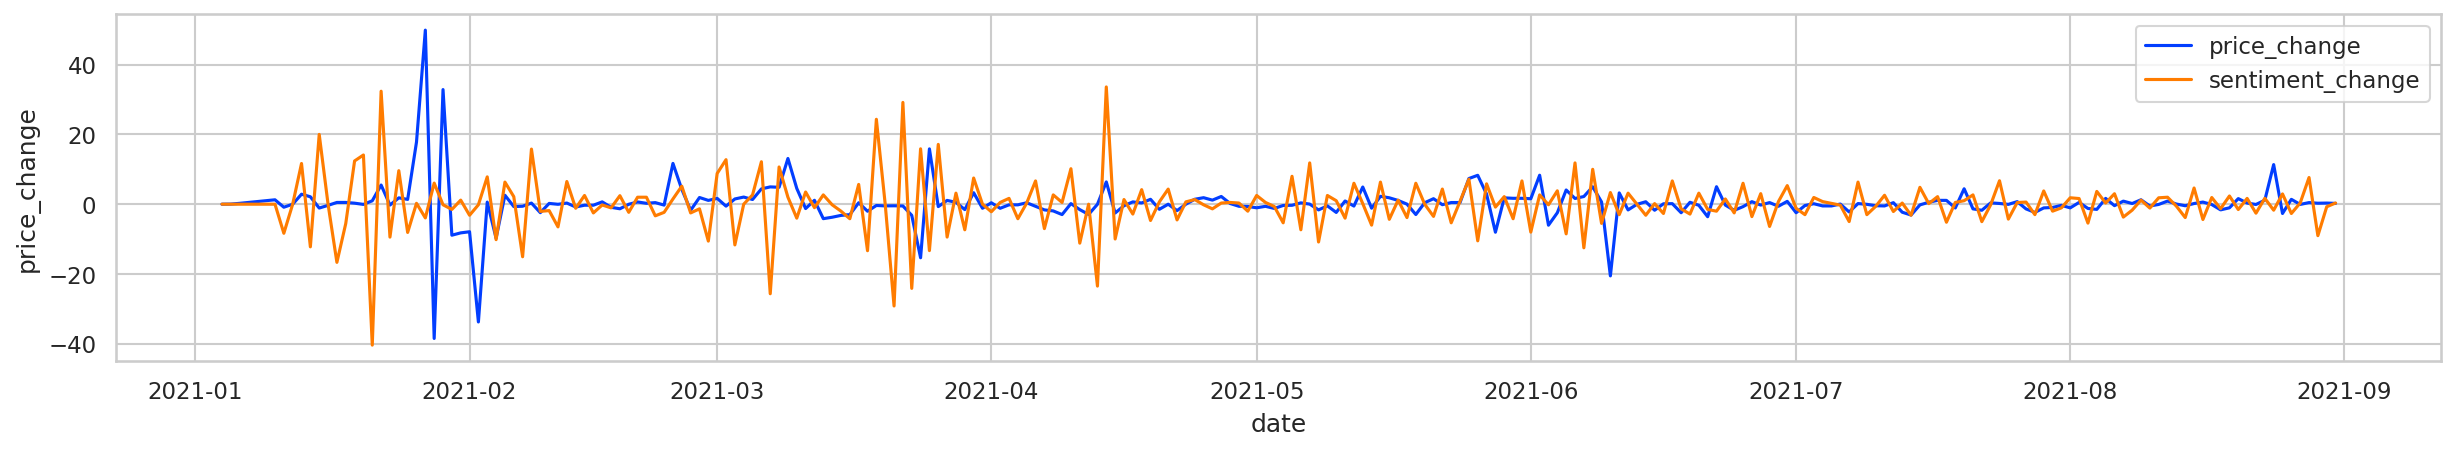

In [96]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(ca['price_change'], label ='price_change')
sns.lineplot(ca['sentiment_change'].diff().fillna(0)*50, label = 'sentiment_change')

<Axes: >

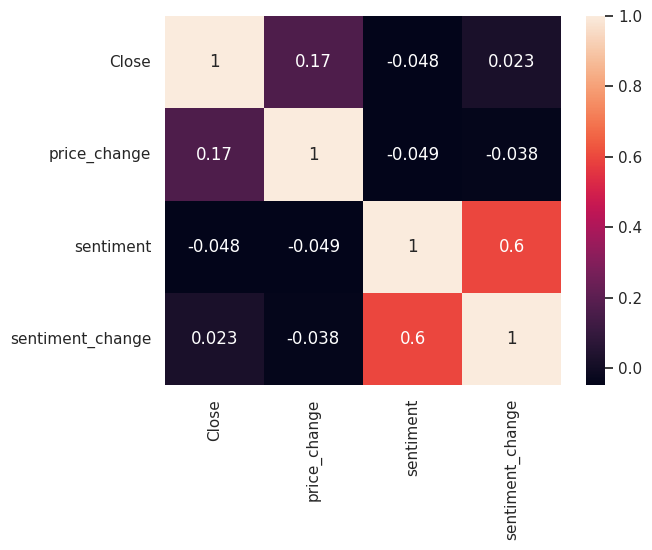

In [97]:
sns.heatmap(ca[['Close','price_change', 'sentiment','sentiment_change']].corr(),annot=True)

When I conducted a correlation analysis between the sentiment data and stock prices, I discovered that the sentiment scores from our fine-tuned BERT model did not correlate strongly with either stock prices or their fluctuations. This lack of correlation could be attributed to a couple of reasons:

1. My BERT model was originally fine-tuned on financial news headlines from Kaggle, which are substantially different from the Reddit posts. This caused a challenge for the model to generalize its findings effectively to the Reddit data.

2. The model's tendency to classify the majority of sentiments as neutral possibly obscured stronger correlations that might have emerged had I focused only on the more definitive positive and negative categories, or if I had used the BERT embeddings directly.

Despite these initial setbacks, this sentiment analysis has established a solid baseline for my research. Moving forward, I plan to train an LSTM model using the sentiment labels derived from this analysis. Afterward, I intend to delve deeper into the potential of BERT embeddings to refine and enhance the model's predictive capability.

#### **LSTM Model**

In [98]:
total_len = len(df_sa)

train = df_sa[df_sa.index<pd.to_datetime("2021-05-01")]
val   = df_sa[(df_sa.index < pd.to_datetime("2021-06-01")) & (df_sa.index > pd.to_datetime("2021-05-01"))]
test  = df_sa[(df_sa.index < pd.to_datetime("2021-09-01")) & (df_sa.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.4810126582278481 val_len 0.12658227848101267 test_len 0.3881856540084388


In [99]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape

Index(['Close', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'sentiment'], dtype='object')


((114, 7), (30, 7), (92, 7))

In [100]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

In [101]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69), (64, 70), (65, 71), (66, 72), (67, 73), (68, 74), (69, 75), (70, 76), (71, 77), (72, 78), (73, 79), (74, 80), (75, 81), (76, 82), (77, 83), (78, 84), (79, 85), (80, 86), (81, 87), (82, 88), (83, 89), (84, 90), (85, 91), (86, 92), (87, 93), (88, 94), (89, 95), (90, 96), (91, 97), (92, 98), (93, 99), (94, 100), (95, 101), (96, 102), (97, 103), (98, 104), (99, 105), (100, 1

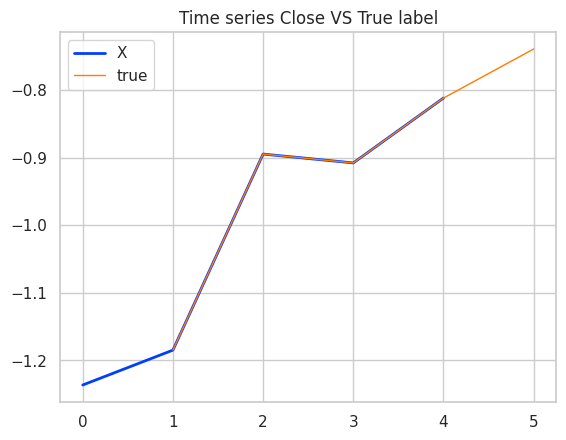

In [102]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

In [103]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [104]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([0.1107, 0.1093, 0.4468, 0.3135, 0.2903], device='cuda:0') tensor([0.1093, 0.4468, 0.3135, 0.2903, 0.3254], device='cuda:0')
x shape: torch.Size([64, 5, 7]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  1.067008M  1.062912M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
---------------------------------------------------------------------
   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [105]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [106]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

#### **Training...**

In [107]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8894	 Learning Rate 0.0020000	 Validation Loss 0.3048

Epoch: 2/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4915	 Learning Rate 0.0016000	 Validation Loss 0.0713

Epoch: 3/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4913	 Learning Rate 0.0012800	 Validation Loss 0.1760

Epoch: 4/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3679	 Learning Rate 0.0010240	 Validation Loss 0.2212

Epoch: 5/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4501	 Learning Rate 0.0008192	 Validation Loss 0.2048

Epoch: 6/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3792	 Learning Rate 0.0006554	 Validation Loss 0.1687

Epoch: 7/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3182	 Learning Rate 0.0005243	 Validation Loss 0.1406

Epoch: 8/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2888	 Learning Rate 0.0004194	 Validation Loss 0.1288

Epoch: 9/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2354	 Learning Rate 0.0003355	 Validation Loss 0.1321

Epoch: 10/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2451	 Learning Rate 0.0002684	 Validation Loss 0.1425

Epoch: 11/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2575	 Learning Rate 0.0002147	 Validation Loss 0.1479

Epoch: 12/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2485	 Learning Rate 0.0001718	 Validation Loss 0.1483

Epoch: 13/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2682	 Learning Rate 0.0001374	 Validation Loss 0.1466

Epoch: 14/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2131	 Learning Rate 0.0001100	 Validation Loss 0.1454

Epoch: 15/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2488	 Learning Rate 0.0000880	 Validation Loss 0.1441

Epoch: 16/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2356	 Learning Rate 0.0000704	 Validation Loss 0.1421

Epoch: 17/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2179	 Learning Rate 0.0000563	 Validation Loss 0.1404

Epoch: 18/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2223	 Learning Rate 0.0000450	 Validation Loss 0.1383

Epoch: 19/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2309	 Learning Rate 0.0000360	 Validation Loss 0.1365

Epoch: 20/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2134	 Learning Rate 0.0000288	 Validation Loss 0.1356

Epoch: 21/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2036	 Learning Rate 0.0000231	 Validation Loss 0.1344

Epoch: 22/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2112	 Learning Rate 0.0000184	 Validation Loss 0.1333

Epoch: 23/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2355	 Learning Rate 0.0000148	 Validation Loss 0.1325

Epoch: 24/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1972	 Learning Rate 0.0000118	 Validation Loss 0.1320

Epoch: 25/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2155	 Learning Rate 0.0000094	 Validation Loss 0.1316

Epoch: 26/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2000	 Learning Rate 0.0000076	 Validation Loss 0.1312

Epoch: 27/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1846	 Learning Rate 0.0000060	 Validation Loss 0.1309

Epoch: 28/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2240	 Learning Rate 0.0000048	 Validation Loss 0.1305

Epoch: 29/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1994	 Learning Rate 0.0000039	 Validation Loss 0.1303

Epoch: 30/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2019	 Learning Rate 0.0000031	 Validation Loss 0.1301

Epoch: 31/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1915	 Learning Rate 0.0000025	 Validation Loss 0.1299

Epoch: 32/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1883	 Learning Rate 0.0000020	 Validation Loss 0.1298

Epoch: 33/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1864	 Learning Rate 0.0000016	 Validation Loss 0.1297

Epoch: 34/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1970	 Learning Rate 0.0000013	 Validation Loss 0.1296

Epoch: 35/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2246	 Learning Rate 0.0000010	 Validation Loss 0.1295

Epoch: 36/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2256	 Learning Rate 0.0000008	 Validation Loss 0.1295

Epoch: 37/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1960	 Learning Rate 0.0000006	 Validation Loss 0.1295

Epoch: 38/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2117	 Learning Rate 0.0000005	 Validation Loss 0.1294

Epoch: 39/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2023	 Learning Rate 0.0000004	 Validation Loss 0.1294

Epoch: 40/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2178	 Learning Rate 0.0000003	 Validation Loss 0.1294

Epoch: 41/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2247	 Learning Rate 0.0000003	 Validation Loss 0.1294

Epoch: 42/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2060	 Learning Rate 0.0000002	 Validation Loss 0.1293

Epoch: 43/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2249	 Learning Rate 0.0000002	 Validation Loss 0.1293

Epoch: 44/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2430	 Learning Rate 0.0000001	 Validation Loss 0.1293

Epoch: 45/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2035	 Learning Rate 0.0000001	 Validation Loss 0.1293

Epoch: 46/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1913	 Learning Rate 0.0000001	 Validation Loss 0.1293

Epoch: 47/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1969	 Learning Rate 0.0000001	 Validation Loss 0.1293

Epoch: 48/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1991	 Learning Rate 0.0000001	 Validation Loss 0.1293

Epoch: 49/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1928	 Learning Rate 0.0000000	 Validation Loss 0.1293

Epoch: 50/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1949	 Learning Rate 0.0000000	 Validation Loss 0.1293


Text(0.5, 1.0, 'Validation loss')

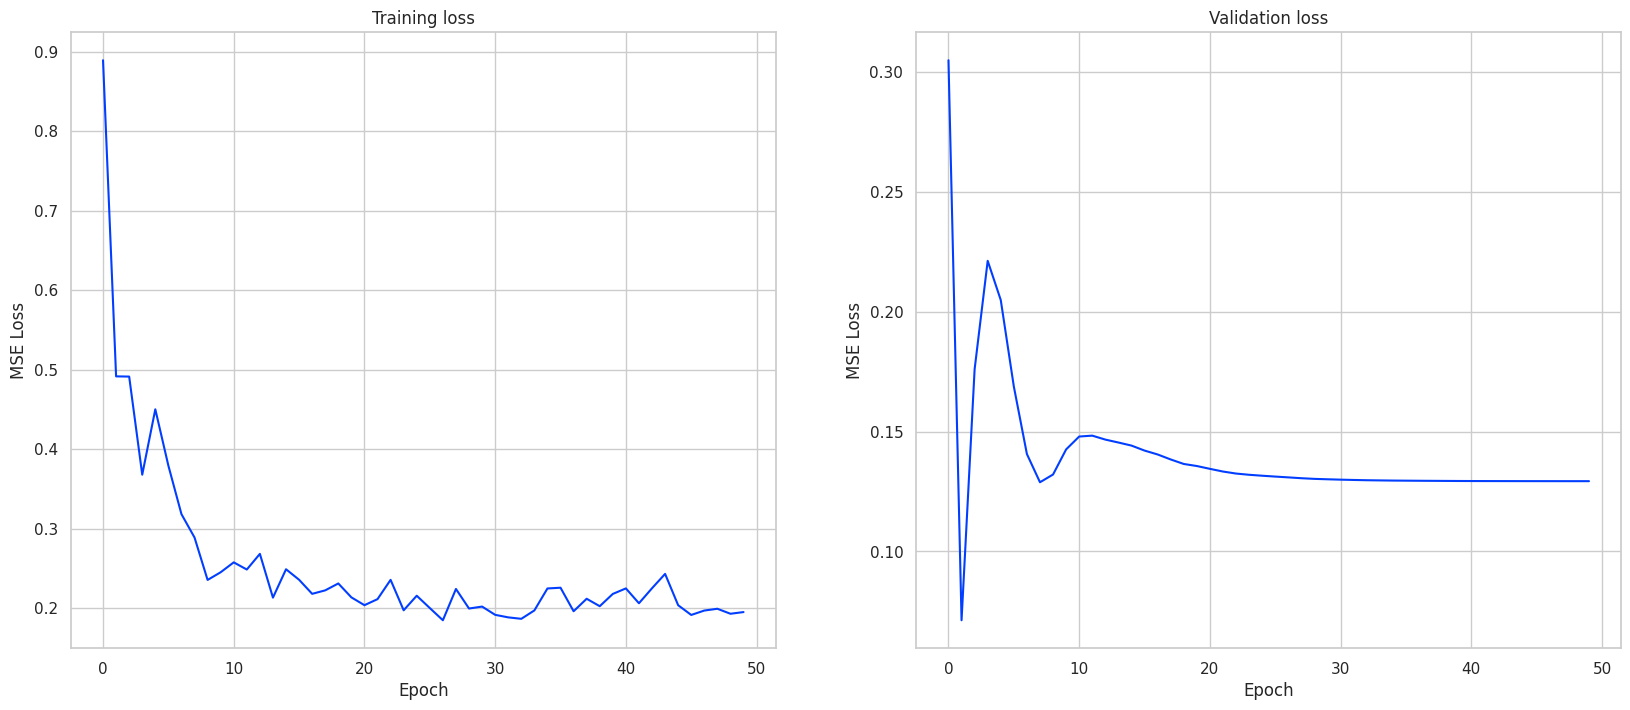

In [108]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")

In [187]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_test_metrics = get_metrics(prediction,true_labels)
metrics2 = baseline_test_metrics
metrics2

Train:   0%|          | 0/4 [00:00<?, ?it/s]

(86,) (86,)


MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),
0  39.280869  6.267445  4.578821  0.100428      0.90147           -0.12183

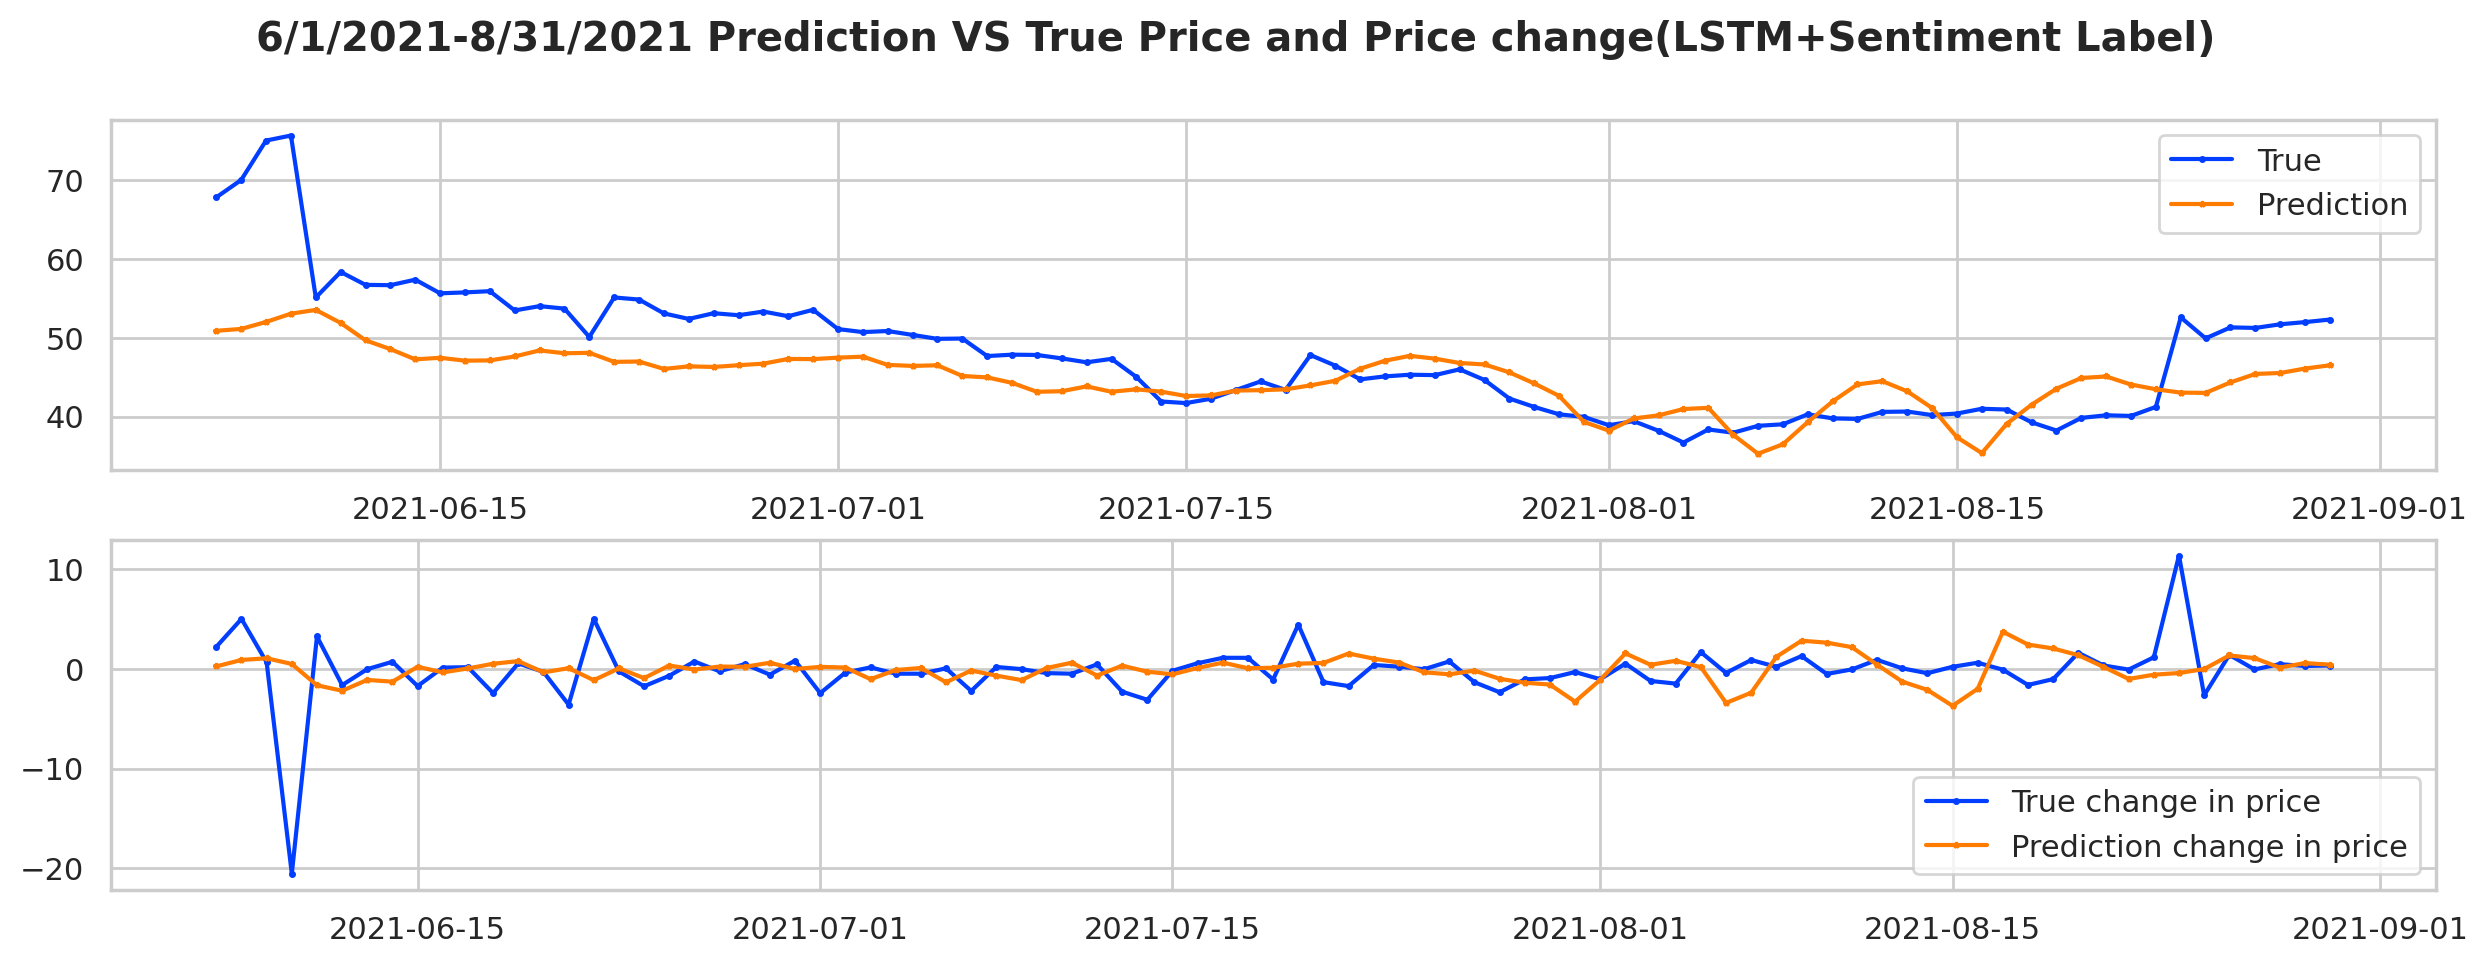

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming true_labels and prediction are numpy arrays or lists containing the true and predicted values.

# Filter the dataframe for the date range you're interested in and get the index as a datetime format
filtered_df = df_sa.loc[pd.to_datetime("2021-06-06"):pd.to_datetime("2021-08-30")]
date = filtered_df.index  # This should give you the date index directly

fig, ax = plt.subplots(2, 1, figsize=(15, 5), dpi=200)
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction', marker='*', markersize=2)
ax[0].legend()

# For the difference/delta plots, make sure the arrays are the correct length
# If true_labels and prediction are one element longer than the date array after diff, you need to slice them
true_changes = np.diff(true_labels)
pred_changes = np.diff(prediction)

# Ensure the lengths of date[1:], true_changes, and pred_changes are all equal
ax[1].plot(date[1:], true_changes, label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], pred_changes, label='Prediction change in price', marker='*', markersize=2)
ax[1].legend()


fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(LSTM+Sentiment Label)", fontweight="bold")
plt.show()


In [189]:
inference_indices = get_windows(df_sa[df_sa.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_sa[df_sa.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [190]:
prediction,true_labels=test(inference_loader)
# prediction = prediction[:,0]
# true_labels=true_labels[:,0]
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_train_test_metrics = get_metrics(prediction,true_labels)
baseline_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(231,) (231,)


MSE    RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),
0  53.237446  7.2964  4.921036  0.135314     0.908386            0.19731

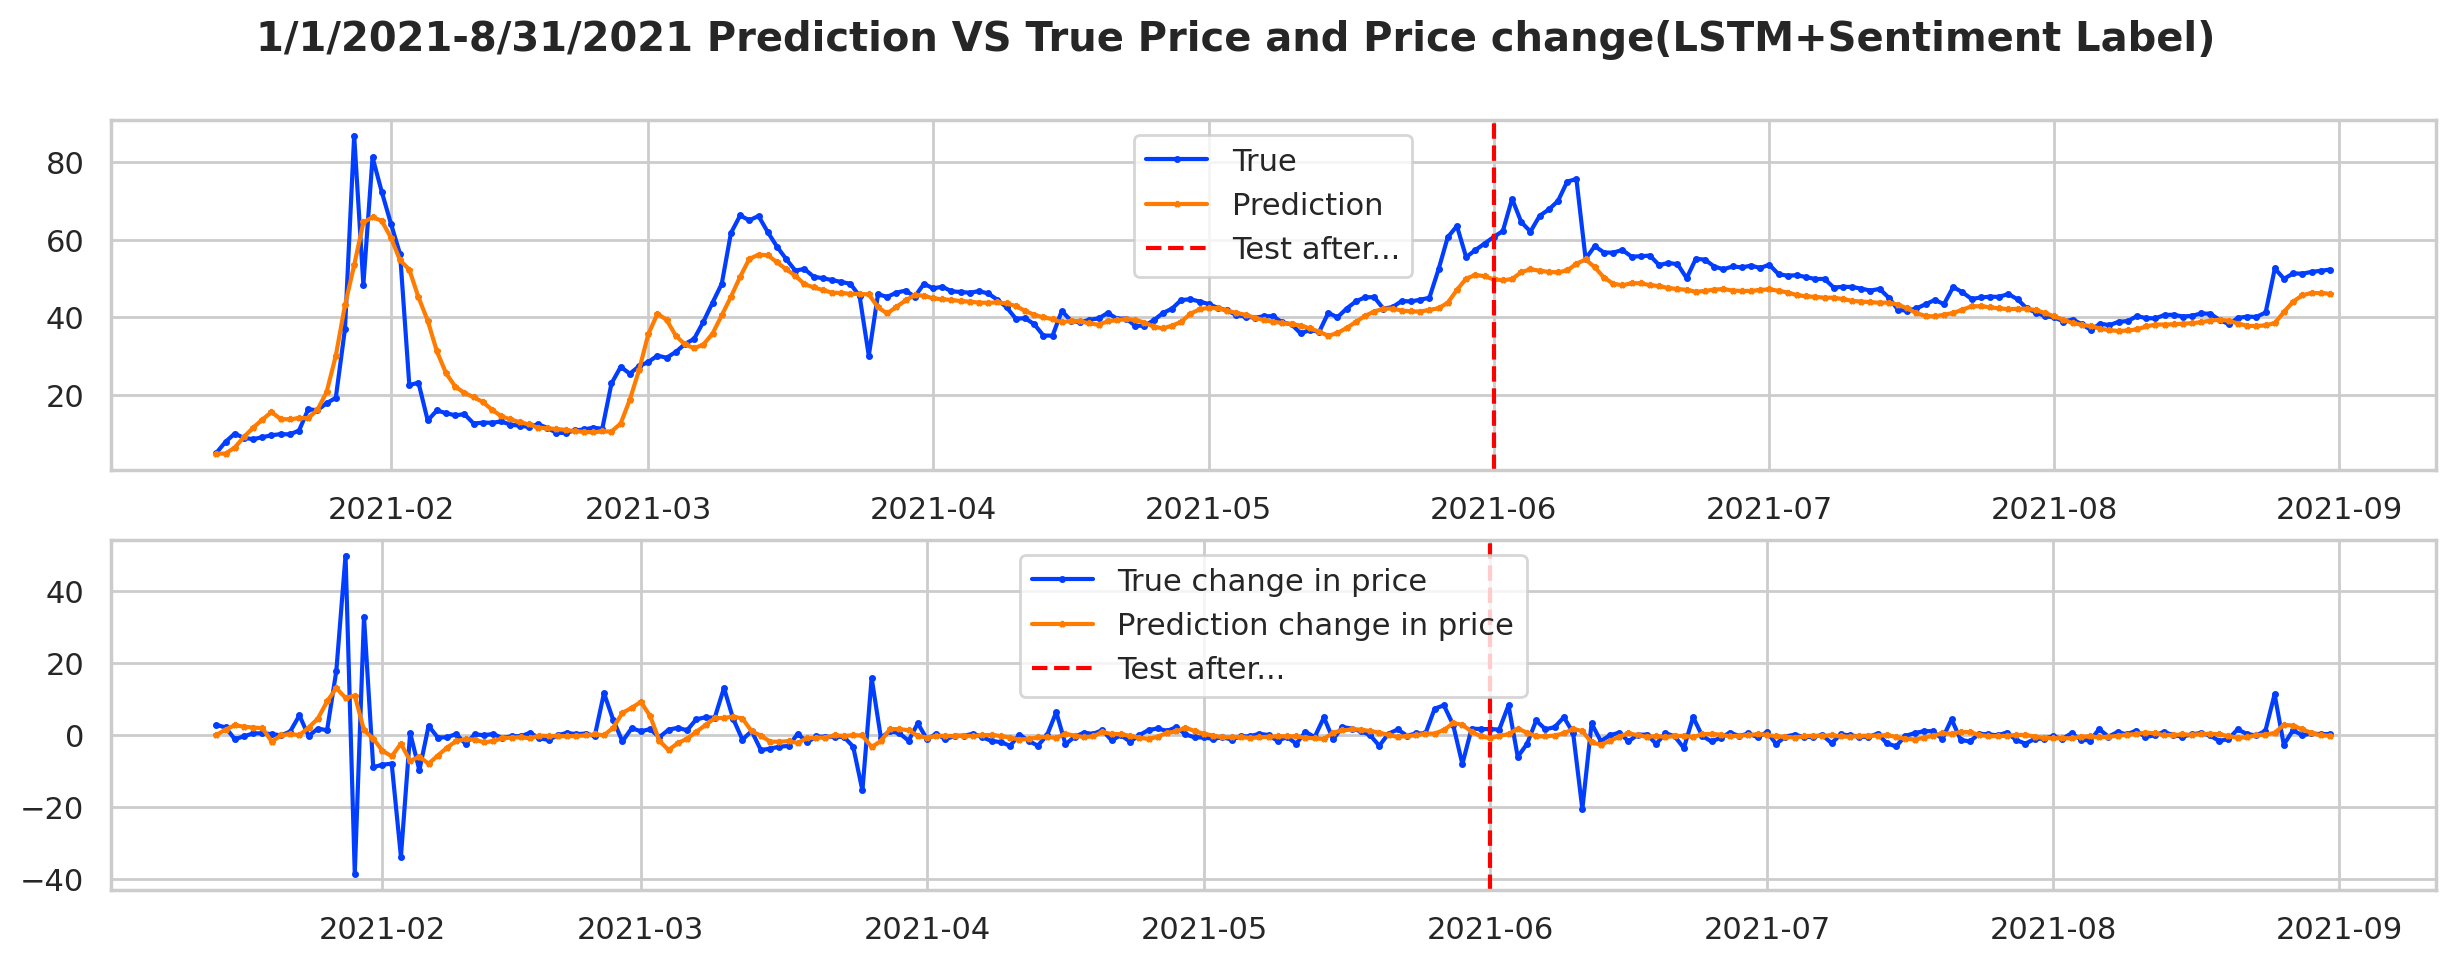

In [191]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming true_labels and prediction are numpy arrays or lists containing the true and predicted values.

# Filter the dataframe for the date range you're interested in and get the index as a datetime format
filtered_df = df_sa.loc[pd.to_datetime("2021-01-13"):pd.to_datetime("2021-08-31")]
date = filtered_df.index  # This set the date index directly

fig, ax = plt.subplots(2, 1, figsize=(15, 5), dpi=200)
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction', marker='*', markersize=2)
ax[0].legend()

# For the difference/delta plots, make sure the arrays are the correct length
# If true_labels and prediction are one element longer than the date array after diff, you need to slice them
true_changes = np.diff(true_labels)
pred_changes = np.diff(prediction)

# Ensure the lengths of date[1:], true_changes, and pred_changes are all equal
ax[1].plot(date[1:], true_changes, label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], pred_changes, label='Prediction change in price', marker='*', markersize=2)
ax[1].legend()

# Define the x-coordinate for the vertical line
vertical_line_date = pd.to_datetime("2021-06-01")

# Add a vertical red dashed line to both subplots
for axi in ax:
    axi.axvline(x=vertical_line_date, color='red', linestyle='--', label='Test after...')

ax[0].legend()
ax[1].legend()

fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(LSTM+Sentiment Label)", fontweight="bold")
plt.show()


### **LSTM with BERT Embeddings**

In [7]:
# load the data previously cleaned and stored
df_text = pd.read_csv('/content/drive/MyDrive/94812/sampled_data_with_senti.csv')
stocks = pd.read_csv('/content/drive/MyDrive/94812/stocks.csv')

df_text = df_text.drop('Unnamed: 0',axis=1)
stocks = stocks.drop('Unnamed: 0',axis=1)
# Ensure the 'date' column is in datetime format
df_text['date'] = pd.to_datetime(df_text['date'])
stocks['date'] = pd.to_datetime(stocks['date'])

#### **Load fine-tuned BERT to generate embeddings**

In [8]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out

In [10]:
df_text.isnull().sum()

date          0
title         0
text         23
text_len      0
sentiment     0
dtype: int64

In [11]:
df_text.dropna(inplace=True)

In [12]:
df_tokenized = df_text['text'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [13]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)


In [14]:
model = torch.load("/content/drive/MyDrive/94812/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 2.0192, -1.3486, -0.8481]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index], self.token_type_ids[index], self.att_mask[index])

In [16]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 256,
    shuffle=False
)


In [17]:
# Assuming your model is already on the GPU
model.to('cuda')

# Now, when you're iterating over your DataLoader
for X in inference_loader:
    # Move all parts of X to the GPU
    input_ids = X[0].to('cuda')
    token_type_ids = X[1].to('cuda')
    attention_mask = X[2].to('cuda')

    print(len(X))
    print(input_ids.shape, token_type_ids.shape, attention_mask.shape)

    # Pass the tensors to the model, which is also on the GPU
    pooler_output = model.bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask).pooler_output

    print(pooler_output.shape)

    break  # Remove this break to process the whole DataLoader


3
torch.Size([256, 50]) torch.Size([256, 50]) torch.Size([256, 50])
torch.Size([256, 768])


In [18]:
embeddings = []

for batch in tqdm(inference_loader, desc="Inferencing..."):
    # Move the batch to the device
    input_ids = batch[0].to(device)
    token_type_ids = batch[1].to(device)
    attention_mask = batch[2].to(device)

    with torch.no_grad():
        # Get the pooler output (which are the embeddings from BERT)
        res = model.bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask).pooler_output

        # Move the result to CPU and convert to NumPy
        embeddings.append(res.cpu().numpy())

# After processing all batches, concatenate the results into one array
embeddings = np.vstack(embeddings)

print("Embeddings shape:", embeddings.shape)

Inferencing...:   0%|          | 0/230 [00:00<?, ?it/s]

Embeddings shape: (58667, 768)


In [19]:
# Convert the embeddings to a DataFrame
df_embeddings = pd.DataFrame(embeddings, columns=['dim' + str(i) for i in range(embeddings.shape[1])])

# Make sure 'Date' is in the same order and has the same length as the embeddings
# Assuming df['Date'] is already sorted and corresponds to the order of embeddings
df_embeddings['date'] = df_text.reset_index()['date']

# Now, group by 'Date' and calculate the mean embeddings for each date
# The assumption here is that 'Date' is not the index of df_embeddings yet
df_embeddings = df_embeddings.groupby('date', as_index=True).mean()
df_embeddings

dim0      dim1      dim2      dim3      dim4      dim5  \
date                                                                     
2021-01-04 -0.822092 -0.407708 -0.754542  0.630981  0.443855 -0.172081   
2021-01-05 -0.703660 -0.244902 -0.236099  0.398721  0.192668  0.044645   
2021-01-06 -0.649098 -0.201185 -0.393793  0.286446  0.285686 -0.028834   
2021-01-10 -0.749846 -0.178721 -0.164226  0.553868  0.210562 -0.021204   
2021-01-11 -0.806845 -0.280078 -0.634535  0.554415  0.359085 -0.159309   
...              ...       ...       ...       ...       ...       ...   
2021-08-27 -0.706101 -0.211400 -0.146356  0.439468  0.162507 -0.067846   
2021-08-28 -0.714087 -0.223346 -0.216478  0.438453  0.193218 -0.059810   
2021-08-29 -0.721784 -0.222458 -0.227090  0.447693  0.208334 -0.075089   
2021-08-30 -0.706203 -0.196056 -0.147479  0.439763  0.155630 -0.074649   
2021-08-31 -0.702920 -0.207316 -0.182706  0.417158  0.148178 -0.074001   

                dim6      dim7      dim8      dim9  ...    dim758    dim759  \
date                                                ...                       
2021-01-04  0.614069  0.165137 -0.353174 -0.999953  ...  0.303872  0.137936   
2021-01-05  0.467691  0.020324 -0.082505 -0.998456  ...  0.402891  0.324570   
2021-01-06  0.284095  0.164742  0.052523 -0.998805  ...  0.330318  0.295623   
2021-01-10  0.648293  0.008617  0.220001 -0.999189  ...  0.208734  0.414403   
2021-01-11  0.549905  0.237420 -0.371172 -0.999621  ...  0.416511  0.276095   
...              ...       ...       ...       ...  ...       ...       ...   
2021-08-27  0.495816  0.148320  0.075067 -0.997327  ...  0.292647  0.405046   
2021-08-28  0.507291  0.121628  0.012555 -0.997508  ...  0.311634  0.331470   
2021-08-29  0.521526  0.147823  0.010370 -0.998668  ...  0.323726  0.378731   
2021-08-30  0.494063  0.144401  0.094312 -0.994427  ...  0.307036  0.438311   
2021-08-31  0.460336  0.142831  0.078308 -0.997084  ...  0.291356  0.453165   

              dim760    dim761    dim762    dim763    dim764    dim765  \
date                                                                     
2021-01-04  0.927452  0.675352  0.037800  0.419769  0.328219 -0.602193   
2021-01-05  0.221052  0.726804  0.396679  0.658154  0.525973 -0.454025   
2021-01-06  0.649835  0.714998 -0.338975  0.460470  0.360507 -0.363926   
2021-01-10  0.389239  0.787298 -0.242059  0.554988  0.346898 -0.219225   
2021-01-11  0.741144  0.744813 -0.082844  0.387353  0.497964 -0.423732   
...              ...       ...       ...       ...       ...       ...   
2021-08-27  0.359957  0.739323  0.072987  0.560638  0.396005 -0.142151   
2021-08-28  0.440869  0.747451  0.017687  0.536743  0.406419 -0.215493   
2021-08-29  0.439444  0.741455  0.034449  0.535914  0.410429 -0.233645   
2021-08-30  0.345506  0.731602  0.048037  0.567041  0.404202 -0.163585   
2021-08-31  0.358756  0.728405  0.105531  0.554368  0.394924 -0.182900   

              dim766    dim767  
date                            
2021-01-04 -0.583052  0.719582  
2021-01-05 -0.476951  0.806471  
2021-01-06 -0.438319  0.600418  
2021-01-10 -0.443810  0.804696  
2021-01-11 -0.544275  0.823558  
...              ...       ...  
2021-08-27 -0.515860  0.778613  
2021-08-28 -0.508734  0.780738  
2021-08-29 -0.520107  0.790527  
2021-08-30 -0.494354  0.780559  
2021-08-31 -0.498017  0.779745  

[237 rows x 768 columns]

#### **Combine with the stock data**

In [20]:
df_bert = stocks.merge(df_embeddings, on='date', how='inner')
print(df_bert.shape)
df_bert.index=df_bert['date']
df_bert = df_bert.drop(columns='date')
df_bert.head()

(237, 775)


Close      Open      High       Low  Adj Close        Volume  \
date                                                                          
2021-01-04  4.312500  4.750000  4.775000  4.287500   4.312500  4.009000e+07   
2021-01-05  4.342500  4.337500  4.520000  4.307500   4.342500  1.984600e+07   
2021-01-06  4.590000  4.335000  4.745000  4.332500   4.590000  2.422480e+07   
2021-01-10  5.851518  4.606354  5.510845  5.486463   5.851518  4.839733e+07   
2021-01-11  4.985000  4.852500  5.162500  4.752500   4.985000  5.963200e+07   

                dim0      dim1      dim2      dim3  ...    dim758    dim759  \
date                                                ...                       
2021-01-04 -0.822092 -0.407708 -0.754542  0.630981  ...  0.303872  0.137936   
2021-01-05 -0.703660 -0.244902 -0.236099  0.398721  ...  0.402891  0.324570   
2021-01-06 -0.649098 -0.201185 -0.393793  0.286446  ...  0.330318  0.295623   
2021-01-10 -0.749846 -0.178721 -0.164226  0.553868  ...  0.208734  0.414403   
2021-01-11 -0.806845 -0.280078 -0.634535  0.554415  ...  0.416511  0.276095   

              dim760    dim761    dim762    dim763    dim764    dim765  \
date                                                                     
2021-01-04  0.927452  0.675352  0.037800  0.419769  0.328219 -0.602193   
2021-01-05  0.221052  0.726804  0.396679  0.658154  0.525973 -0.454025   
2021-01-06  0.649835  0.714998 -0.338975  0.460470  0.360507 -0.363926   
2021-01-10  0.389239  0.787298 -0.242059  0.554988  0.346898 -0.219225   
2021-01-11  0.741144  0.744813 -0.082844  0.387353  0.497964 -0.423732   

              dim766    dim767  
date                            
2021-01-04 -0.583052  0.719582  
2021-01-05 -0.476951  0.806471  
2021-01-06 -0.438319  0.600418  
2021-01-10 -0.443810  0.804696  
2021-01-11 -0.544275  0.823558  

[5 rows x 774 columns]

#### **LSTM+BERT**

In [21]:
total_len = len(df_bert)

train = df_bert[df_bert.index<pd.to_datetime("2021-05-01")]
val   = df_bert[(df_bert.index < pd.to_datetime("2021-06-01")) & (df_bert.index > pd.to_datetime("2021-05-01"))]
test  = df_bert[(df_bert.index < pd.to_datetime("2021-09-01")) & (df_bert.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.4810126582278481 val_len 0.12658227848101267 test_len 0.3881856540084388


In [22]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape

Index(['Close', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'dim0', 'dim1',
       'dim2', 'dim3',
       ...
       'dim758', 'dim759', 'dim760', 'dim761', 'dim762', 'dim763', 'dim764',
       'dim765', 'dim766', 'dim767'],
      dtype='object', length=774)


((114, 774), (30, 774), (92, 774))

In [23]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

In [24]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69), (64, 70), (65, 71), (66, 72), (67, 73), (68, 74), (69, 75), (70, 76), (71, 77), (72, 78), (73, 79), (74, 80), (75, 81), (76, 82), (77, 83), (78, 84), (79, 85), (80, 86), (81, 87), (82, 88), (83, 89), (84, 90), (85, 91), (86, 92), (87, 93), (88, 94), (89, 95), (90, 96), (91, 97), (92, 98), (93, 99), (94, 100), (95, 101), (96, 102), (97, 103), (98, 104), (99, 105), (100, 1

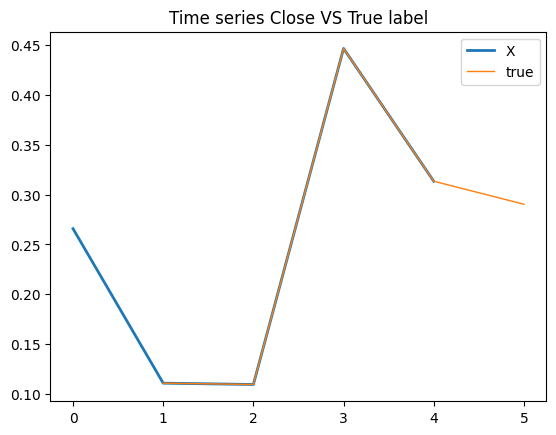

In [25]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

In [26]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [27]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


tensor([-1.3019, -1.2753, -1.2487, -1.2333, -1.2365], device='cuda:0') tensor([-1.2753, -1.2487, -1.2333, -1.2365, -1.1848], device='cuda:0')
x shape: torch.Size([64, 5, 774]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  2.637824M  2.633728M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
-------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [28]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [29]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

In [30]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9332	 Learning Rate 0.0020000	 Validation Loss 0.4523

Epoch: 2/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5933	 Learning Rate 0.0016000	 Validation Loss 0.7068

Epoch: 3/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3003	 Learning Rate 0.0012800	 Validation Loss 0.1325

Epoch: 4/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2589	 Learning Rate 0.0010240	 Validation Loss 0.2628

Epoch: 5/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1742	 Learning Rate 0.0008192	 Validation Loss 0.3398

Epoch: 6/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1541	 Learning Rate 0.0006554	 Validation Loss 0.2979

Epoch: 7/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0910	 Learning Rate 0.0005243	 Validation Loss 0.2815

Epoch: 8/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0759	 Learning Rate 0.0004194	 Validation Loss 0.3051

Epoch: 9/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0971	 Learning Rate 0.0003355	 Validation Loss 0.3057

Epoch: 10/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0858	 Learning Rate 0.0002684	 Validation Loss 0.2938

Epoch: 11/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0775	 Learning Rate 0.0002147	 Validation Loss 0.2862

Epoch: 12/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0904	 Learning Rate 0.0001718	 Validation Loss 0.2732

Epoch: 13/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0558	 Learning Rate 0.0001374	 Validation Loss 0.2665

Epoch: 14/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0663	 Learning Rate 0.0001100	 Validation Loss 0.2644

Epoch: 15/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0682	 Learning Rate 0.0000880	 Validation Loss 0.2665

Epoch: 16/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0590	 Learning Rate 0.0000704	 Validation Loss 0.2720

Epoch: 17/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0648	 Learning Rate 0.0000563	 Validation Loss 0.2778

Epoch: 18/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0566	 Learning Rate 0.0000450	 Validation Loss 0.2818

Epoch: 19/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0531	 Learning Rate 0.0000360	 Validation Loss 0.2876

Epoch: 20/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0763	 Learning Rate 0.0000288	 Validation Loss 0.2908

Epoch: 21/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0475	 Learning Rate 0.0000231	 Validation Loss 0.2932

Epoch: 22/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0403	 Learning Rate 0.0000184	 Validation Loss 0.2942

Epoch: 23/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0591	 Learning Rate 0.0000148	 Validation Loss 0.2947

Epoch: 24/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0606	 Learning Rate 0.0000118	 Validation Loss 0.2945

Epoch: 25/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0751	 Learning Rate 0.0000094	 Validation Loss 0.2937

Epoch: 26/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0659	 Learning Rate 0.0000076	 Validation Loss 0.2932

Epoch: 27/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0559	 Learning Rate 0.0000060	 Validation Loss 0.2927

Epoch: 28/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0681	 Learning Rate 0.0000048	 Validation Loss 0.2920

Epoch: 29/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0856	 Learning Rate 0.0000039	 Validation Loss 0.2916

Epoch: 30/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0607	 Learning Rate 0.0000031	 Validation Loss 0.2912

Epoch: 31/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0630	 Learning Rate 0.0000025	 Validation Loss 0.2909

Epoch: 32/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0473	 Learning Rate 0.0000020	 Validation Loss 0.2907

Epoch: 33/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0616	 Learning Rate 0.0000016	 Validation Loss 0.2906

Epoch: 34/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0598	 Learning Rate 0.0000013	 Validation Loss 0.2905

Epoch: 35/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0632	 Learning Rate 0.0000010	 Validation Loss 0.2904

Epoch: 36/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0533	 Learning Rate 0.0000008	 Validation Loss 0.2903

Epoch: 37/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0743	 Learning Rate 0.0000006	 Validation Loss 0.2903

Epoch: 38/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0629	 Learning Rate 0.0000005	 Validation Loss 0.2903

Epoch: 39/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0594	 Learning Rate 0.0000004	 Validation Loss 0.2903

Epoch: 40/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0489	 Learning Rate 0.0000003	 Validation Loss 0.2903

Epoch: 41/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0592	 Learning Rate 0.0000003	 Validation Loss 0.2902

Epoch: 42/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0650	 Learning Rate 0.0000002	 Validation Loss 0.2902

Epoch: 43/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0563	 Learning Rate 0.0000002	 Validation Loss 0.2902

Epoch: 44/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0619	 Learning Rate 0.0000001	 Validation Loss 0.2902

Epoch: 45/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0606	 Learning Rate 0.0000001	 Validation Loss 0.2901

Epoch: 46/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0672	 Learning Rate 0.0000001	 Validation Loss 0.2901

Epoch: 47/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0659	 Learning Rate 0.0000001	 Validation Loss 0.2901

Epoch: 48/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0559	 Learning Rate 0.0000001	 Validation Loss 0.2901

Epoch: 49/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0558	 Learning Rate 0.0000000	 Validation Loss 0.2901

Epoch: 50/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0659	 Learning Rate 0.0000000	 Validation Loss 0.2901


Text(0.5, 1.0, 'Validation loss')

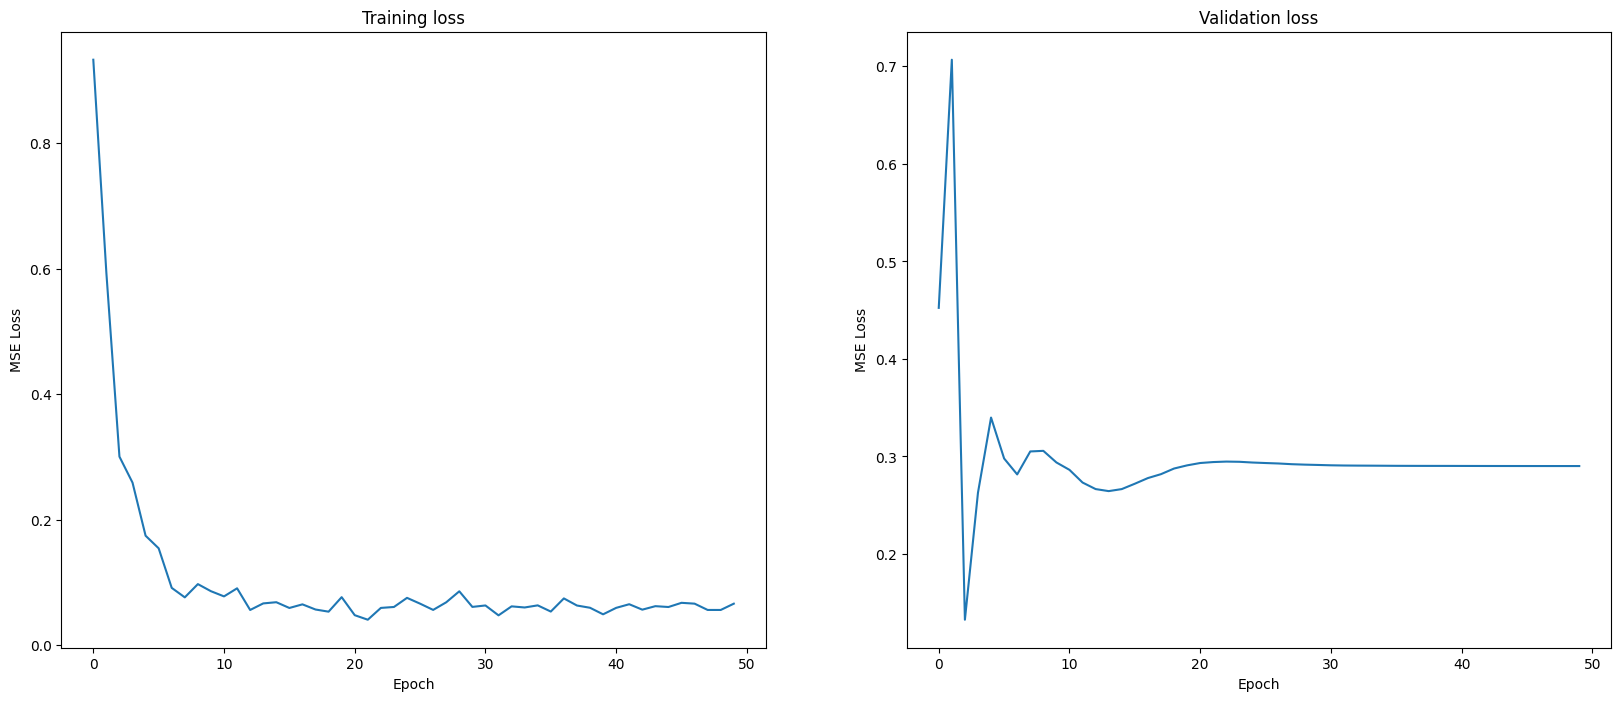

In [31]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")

In [32]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_test_metrics = get_metrics(prediction,true_labels)
metrics3 = baseline_test_metrics
metrics3

Train:   0%|          | 0/4 [00:00<?, ?it/s]

(86,) (86,)


MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),
0  77.085526  8.779836  6.669606  0.150657     0.109822           0.022462

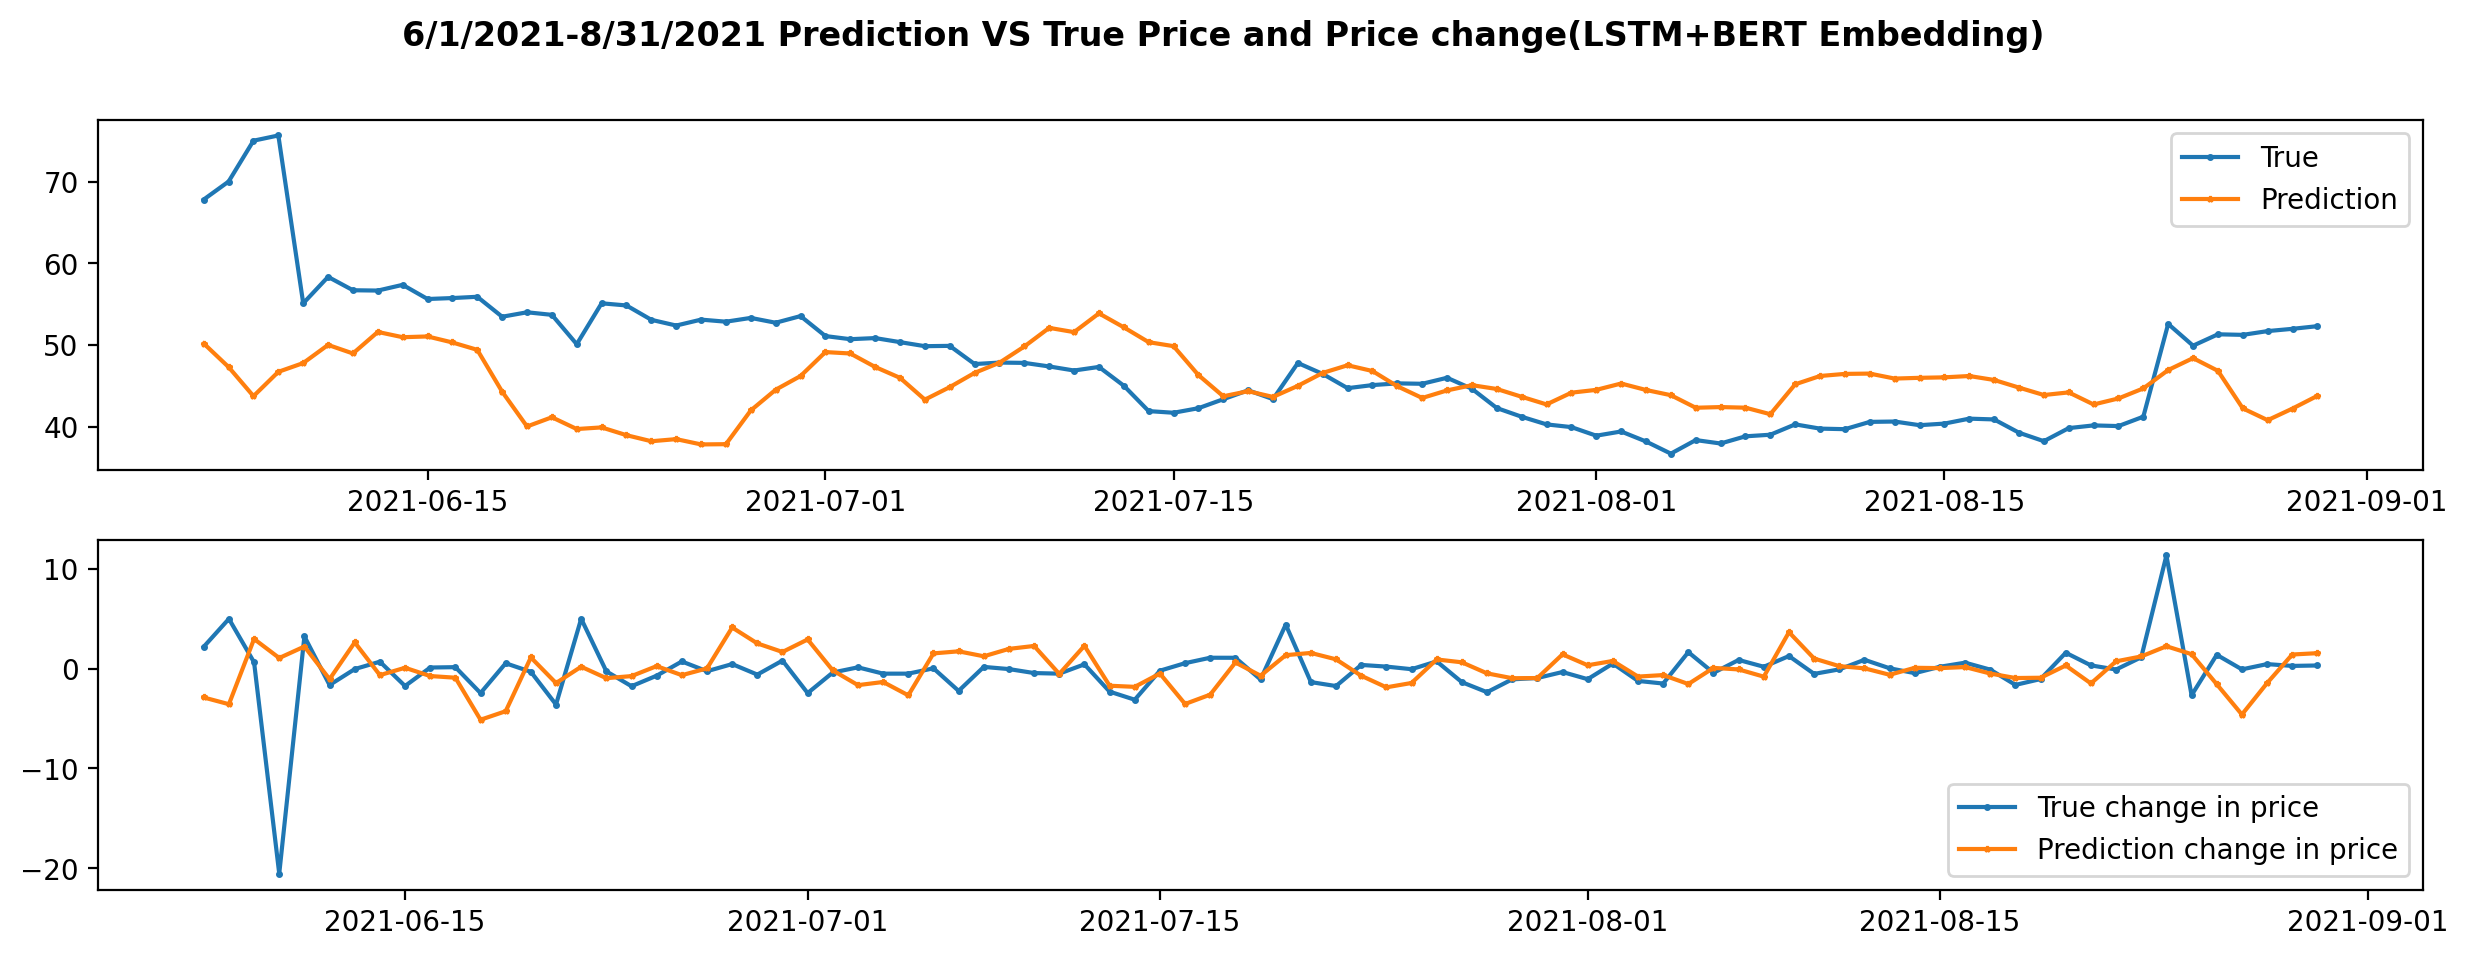

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming true_labels and prediction are numpy arrays or lists containing the true and predicted values.

# Filter the dataframe for the date range you're interested in and get the index as a datetime format
filtered_df = df_bert.loc[pd.to_datetime("2021-06-06"):pd.to_datetime("2021-08-30")]
date = filtered_df.index  # This should give you the date index directly

fig, ax = plt.subplots(2, 1, figsize=(15, 5), dpi=200)
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction', marker='*', markersize=2)
ax[0].legend()

# For the difference/delta plots, make sure the arrays are the correct length
# If true_labels and prediction are one element longer than the date array after diff, you need to slice them
true_changes = np.diff(true_labels)
pred_changes = np.diff(prediction)

# Ensure the lengths of date[1:], true_changes, and pred_changes are all equal
ax[1].plot(date[1:], true_changes, label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], pred_changes, label='Prediction change in price', marker='*', markersize=2)
ax[1].legend()

fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(LSTM+BERT Embedding)", fontweight="bold")
plt.show()


### **Performance Comparison**

In [37]:
df_baseline = metrics1
df_sentiment = metrics2
df_embeddings = metrics3

# Concatenate the three DataFrames into a single DataFrame
df_combined = pd.concat([df_baseline, df_sentiment, df_embeddings], ignore_index=True)

model_names = ['Baseline LSTM', 'LSTM with Sentiment', 'LSTM with BERT Embeddings']
df_combined['Model'] = model_names

# Reorder columns to have 'Model' as the first column
df_combined = df_combined[['Model'] + [col for col in df_combined.columns if col != 'Model']]

df_combined

Model        MSE      RMSE       MAE      MAPE  \
0              Baseline LSTM  42.243553  6.499504  4.629339  0.101011   
1        LSTM with Sentiment  39.280870  6.267445  4.578821  0.100428   
2  LSTM with BERT Embeddings  77.085526  8.779836  6.669606  0.150657   

   Serial Corr  Pearson Corr(IC),  
0     0.897313          -0.155132  
1     0.901470          -0.121830  
2     0.109822           0.022462

The LSTM with Sentiment emerges as the preferable model, combining robust error metrics with the highest serial correlation. This indicates its proficiency in capturing the temporal progression of the dataset, which is essential in predicting sequential data like financial time series. Its slightly less negative Pearson Correlation (IC) compared to the Baseline LSTM implies a somewhat better capability to forecast the correct direction of price movements, a crucial aspect of financial predictions.

The underperformance of the LSTM with BERT Embeddings can likely be explained by the domain-specific fine-tuning of the BERT model. Since it was fine-tuned on Kaggle's financial news headlines, the model might have over-specialized in the language and sentiment of that particular dataset. This would be a problem when applied to Reddit posts, which likely diverge in style, slang, and subject matter from formal financial news. Consequently, the LSTM with BERT Embeddings model fails to generalize well to the Reddit data, reflected in its high error metrics and low serial correlation, indicating a poor fit for the task at hand.

## **GameStop Short Squeeze and Model Adaptation**

### **Event Analysis**

Explore the social media landscape surrounding the GameStop short squeeze in January 2021.

In [89]:
event = pd.read_csv('/content/drive/MyDrive/94812/sampled_data_with_senti.csv')
event.drop(['Unnamed: 0'],axis=1,inplace=True)
event.head()

date                                              title  \
0  2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀   
1  2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀   
2  2021-01-05  You already know what we must do brothers and ...   
3  2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...   
4  2021-01-06  Hey guys! We have a free discord channel that'...   

                                                text  text_len  sentiment  
0  short squeeze incoming rocket rocket rocket ro...        71          0  
1  you need to see this about gme rocket rocket r...        72          0  
2  you already know what we must do brothers and ...        95          0  
3  this convinced me to all in money_bag gme (ext...        63          0  
4  hey guys! we have a free discord channel that'...        87          0

In [90]:
# keep the in January 2021
event = event[(event['date'] < '2021-01-31')]

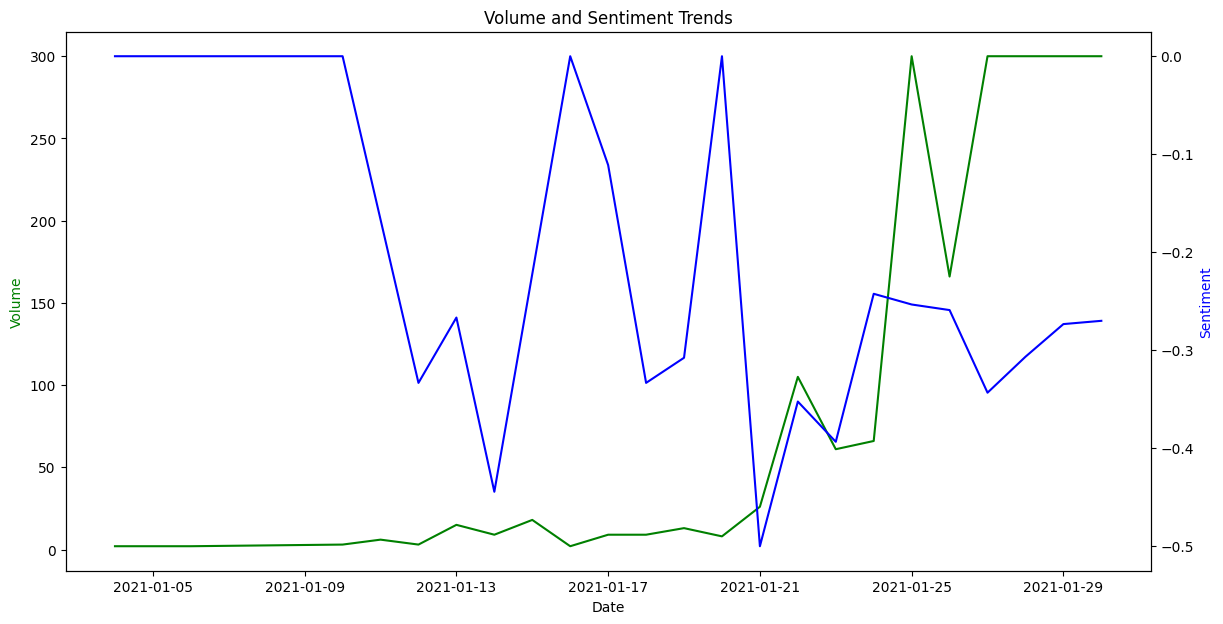

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Assuming df is your dataframe with 'date', 'cleaned_text', and 'sentiment' columns
event['date'] = pd.to_datetime(event['date'])

# Volume Analysis
daily_volume = event.groupby('date').size()

# Sentiment Analysis
daily_sentiment = event.groupby('date')['sentiment'].mean()  # Assuming sentiment is numerical

# Volume and Sentiment Trend Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

ax2 = ax1.twinx()
ax1.plot(daily_volume.index, daily_volume.values, 'g-')
ax2.plot(daily_sentiment.index, daily_sentiment.values, 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='g')
ax2.set_ylabel('Sentiment', color='b')

plt.title('Volume and Sentiment Trends')
plt.show()

#### **Topic Modeling**

In [94]:
event.isnull().sum()
event.dropna(inplace=True)

In [96]:
# Topic Modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(event['text'])

lda = LDA(n_components=5, random_state=0)
lda.fit(doc_term_matrix)

# Display the top words in the topics
for index, topic in enumerate(lda.components_):
    print(f"Top words in topic {index}")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("\n")

Top words in topic 0
['money_bag', 'wallstreetbets', 'gorilla', 'make', 'question', 'price', 'just', 'gamestop', 'wsb', 'gme']


Top words in topic 1
['holding', 'market', 'new', 'shares', 'today', 'buying', 'guys', 'stock', 'gem_stone', 'gme']


Top words in topic 2
['face_with_tears_of_joy', 'buy', 'bought', 'just', 'shares', 'moon', 'gme', 'raising_hands', 'gem_stone', 'rocket']


Top words in topic 3
['like', 'dont', 'fucking', 'lets', 'money', 'line', 'robinhood', 'know', 'shorts', 'hold']


Top words in topic 4
['limit', 'read', 'time', 'hold', 'dip', 'squeeze', 'short', 'sell', 'gme', 'buy']




The topic modeling from social media posts gives a broad overview of the community's interests during the GameStop event, though not as specific as one might find in dedicated articles. The discussions range from investment strategies and market speculation to emotional reactions and commentary on market manipulation. Key themes include the holding and buying of GameStop stock, the collective enthusiasm of the community, reactions to the actions of platforms like Robinhood, and strategies in response to market volatility. The topics reflect a mix of technical trading terms and colloquial speech, illustrating the fierce and passionate nature of the discussions on platforms during this event.

### **Model Sensitivity**

Given that LSTM with sentiment label is better than with BERT embeddings in this case. I will test upon this model.

In [65]:
# load the data previously cleaned and stored
df_senti = pd.read_csv('/content/drive/MyDrive/94812/sampled_data_with_senti.csv')
stocks = pd.read_csv('/content/drive/MyDrive/94812/stocks.csv')

df_senti = df_senti.drop('Unnamed: 0',axis=1)
stocks = stocks.drop('Unnamed: 0',axis=1)
# Ensure the 'date' column is in datetime format
df_senti['date'] = pd.to_datetime(df_senti['date'])
stocks['date'] = pd.to_datetime(stocks['date'])

In [66]:
df_senti = df_senti.groupby('date')['sentiment'].mean().reset_index()
df_senti

date  sentiment
0   2021-01-04   0.000000
1   2021-01-05   0.000000
2   2021-01-06   0.000000
3   2021-01-10   0.000000
4   2021-01-11  -0.166667
..         ...        ...
232 2021-08-27  -0.289562
233 2021-08-28  -0.152866
234 2021-08-29  -0.196532
235 2021-08-30  -0.254902
236 2021-08-31  -0.306338

[237 rows x 2 columns]

In [67]:
df_senti.dtypes

date         datetime64[ns]
sentiment           float64
dtype: object

Text(0.5, 1.0, 'Sentiment changing trend')

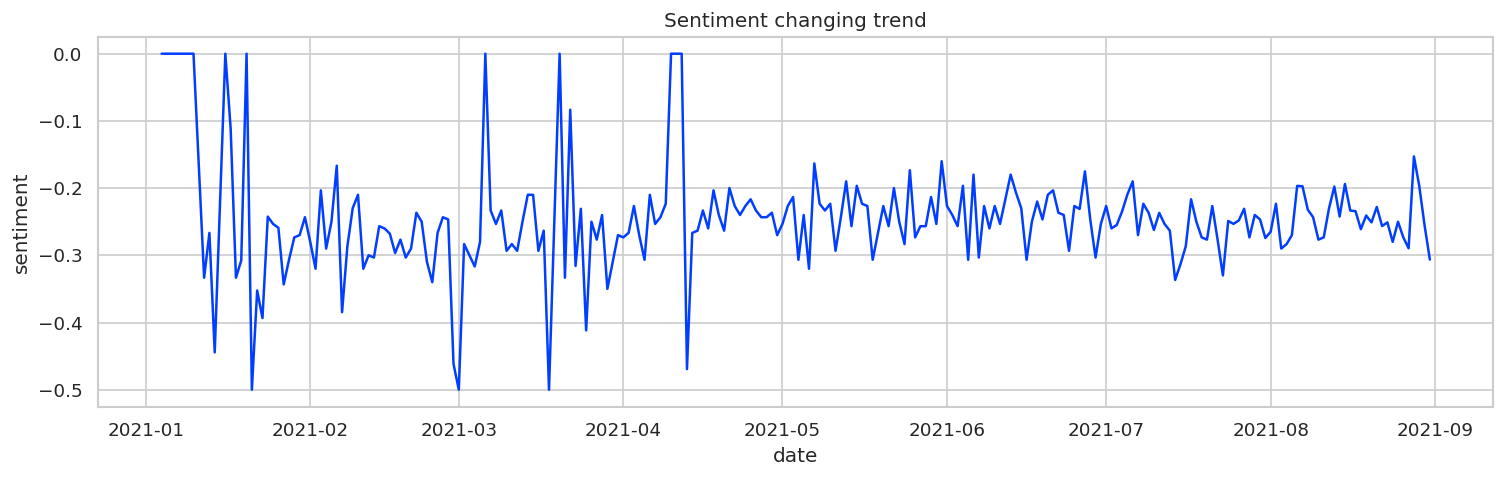

In [68]:
date= df_senti.index  # This set the date index directly

plt.figure(figsize=(15,4),dpi=120)
sns.set(style="whitegrid", palette="bright")
sns.lineplot(data=df_senti, x="date", y="sentiment")
plt.title("Sentiment changing trend")


Text(0.5, 1.0, 'Actual stock price changing trend')

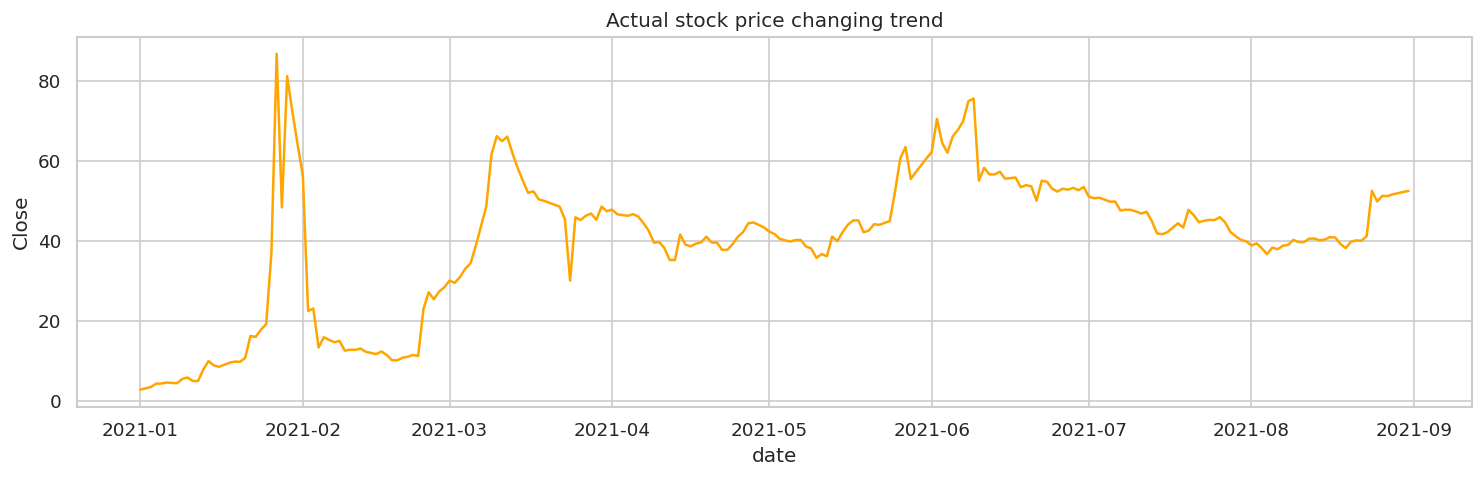

In [69]:
date= df_senti.index  # This set the date index directly

plt.figure(figsize=(15,4),dpi=120)
sns.set(style="whitegrid", palette="bright")
sns.lineplot(data=stocks, x="date", y="Close", color = 'orange')
plt.title("Actual stock price changing trend")


Let's replace some sentiment values with some extreme emotions (1 or -1)to simulate spikes

In [70]:
df = df_senti.copy()

# Load your dataframe here
# df = pd.read_csv('path_to_your_csv.csv')

# For demonstration, let's assume we have a DataFrame named df
# Make sure your 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Define the start and end date for the period we're interested in
start_date = '2021-06-01'
end_date = '2021-08-31'

# Filter the dataframe to the dates we want to modify
mask = (df['date'] >= start_date) & (df['date'] <= end_date)
dates_to_modify = df.loc[mask]

# Randomly replace some sentiments in this date range with 1 or -1
# We'll replace 10% of the data as an example
num_entries = len(dates_to_modify)
indices_to_replace = np.random.choice(dates_to_modify.index, size=int(num_entries * 0.5), replace=False)

df.loc[indices_to_replace, 'sentiment'] = np.random.choice([-1, 1], size=len(indices_to_replace))

# Now df contains the updated sentiment values


Text(0.5, 1.0, 'Sentiment changing trend (Simulated)')

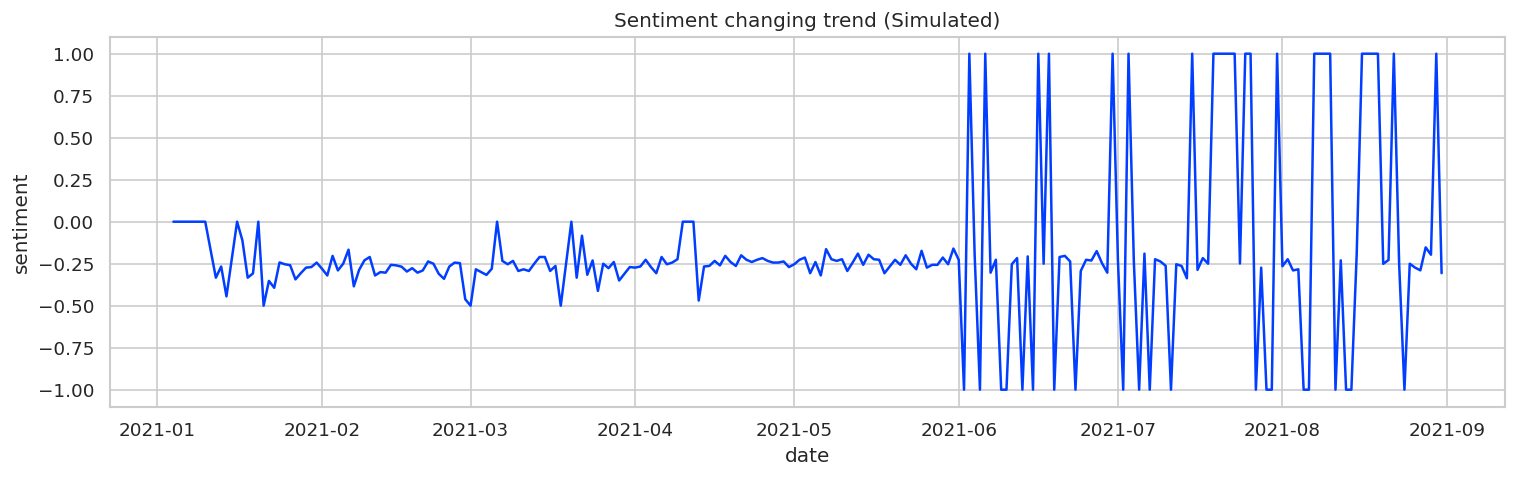

In [71]:
date= df.index  # This set the date index directly

plt.figure(figsize=(15,4),dpi=120)
sns.set(style="whitegrid", palette="bright")
sns.lineplot(data=df, x="date", y="sentiment")
plt.title("Sentiment changing trend (Simulated)")

In [72]:
df_senti=df

In [73]:
df_sa = stocks.merge(df_senti, on='date', how='inner')
print(df_sa.shape)
df_sa.head()

(237, 8)


date     Close      Open      High       Low  Adj Close        Volume  \
0 2021-01-04  4.312500  4.750000  4.775000  4.287500   4.312500  4.009000e+07   
1 2021-01-05  4.342500  4.337500  4.520000  4.307500   4.342500  1.984600e+07   
2 2021-01-06  4.590000  4.335000  4.745000  4.332500   4.590000  2.422480e+07   
3 2021-01-10  5.851518  4.606354  5.510845  5.486463   5.851518  4.839733e+07   
4 2021-01-11  4.985000  4.852500  5.162500  4.752500   4.985000  5.963200e+07   

   sentiment  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4  -0.166667

In [74]:
df_sa['date'] = pd.to_datetime(df_sa['date'])
df_sa.index = df_sa['date']
df_sa=df_sa.drop(columns=['date'])
df_sa.head()

Close      Open      High       Low  Adj Close        Volume  \
date                                                                          
2021-01-04  4.312500  4.750000  4.775000  4.287500   4.312500  4.009000e+07   
2021-01-05  4.342500  4.337500  4.520000  4.307500   4.342500  1.984600e+07   
2021-01-06  4.590000  4.335000  4.745000  4.332500   4.590000  2.422480e+07   
2021-01-10  5.851518  4.606354  5.510845  5.486463   5.851518  4.839733e+07   
2021-01-11  4.985000  4.852500  5.162500  4.752500   4.985000  5.963200e+07   

            sentiment  
date                   
2021-01-04   0.000000  
2021-01-05   0.000000  
2021-01-06   0.000000  
2021-01-10   0.000000  
2021-01-11  -0.166667

Train test split

In [75]:
total_len = len(df_sa)

train = df_sa[df_sa.index<pd.to_datetime("2021-05-01")]
val   = df_sa[(df_sa.index < pd.to_datetime("2021-06-01")) & (df_sa.index > pd.to_datetime("2021-05-01"))]
test  = df_sa[(df_sa.index < pd.to_datetime("2021-09-01")) & (df_sa.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.4810126582278481 val_len 0.12658227848101267 test_len 0.3881856540084388


In [76]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape

Index(['Close', 'Open', 'High', 'Low', 'Adj Close', 'Volume', 'sentiment'], dtype='object')


((114, 7), (30, 7), (92, 7))

In [77]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

In [78]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69), (64, 70), (65, 71), (66, 72), (67, 73), (68, 74), (69, 75), (70, 76), (71, 77), (72, 78), (73, 79), (74, 80), (75, 81), (76, 82), (77, 83), (78, 84), (79, 85), (80, 86), (81, 87), (82, 88), (83, 89), (84, 90), (85, 91), (86, 92), (87, 93), (88, 94), (89, 95), (90, 96), (91, 97), (92, 98), (93, 99), (94, 100), (95, 101), (96, 102), (97, 103), (98, 104), (99, 105), (100, 1

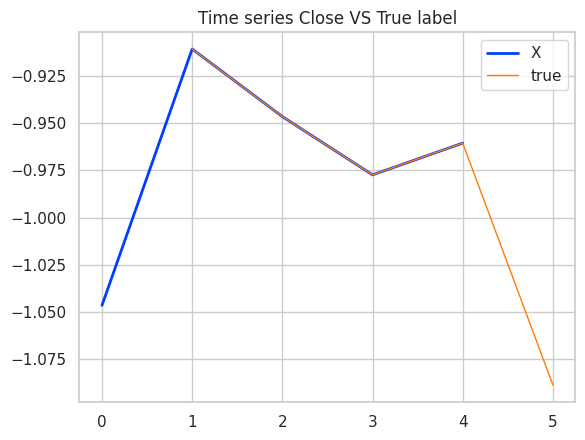

In [79]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

In [80]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [81]:

#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([-0.1127, -0.0048,  0.0664,  0.2983,  0.5601], device='cuda:0') tensor([-0.0048,  0.0664,  0.2983,  0.5601,  0.8163], device='cuda:0')
x shape: torch.Size([64, 5, 7]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  1.067008M  1.062912M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
---------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [82]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [83]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

In [84]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9110	 Learning Rate 0.0020000	 Validation Loss 0.2746

Epoch: 2/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4249	 Learning Rate 0.0016000	 Validation Loss 0.1216

Epoch: 3/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5346	 Learning Rate 0.0012800	 Validation Loss 0.1913

Epoch: 4/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3505	 Learning Rate 0.0010240	 Validation Loss 0.3143

Epoch: 5/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3684	 Learning Rate 0.0008192	 Validation Loss 0.3402

Epoch: 6/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3775	 Learning Rate 0.0006554	 Validation Loss 0.2907

Epoch: 7/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3022	 Learning Rate 0.0005243	 Validation Loss 0.2372

Epoch: 8/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2964	 Learning Rate 0.0004194	 Validation Loss 0.1922

Epoch: 9/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2718	 Learning Rate 0.0003355	 Validation Loss 0.1550

Epoch: 10/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2421	 Learning Rate 0.0002684	 Validation Loss 0.1282

Epoch: 11/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2391	 Learning Rate 0.0002147	 Validation Loss 0.1111

Epoch: 12/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2421	 Learning Rate 0.0001718	 Validation Loss 0.1026

Epoch: 13/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2354	 Learning Rate 0.0001374	 Validation Loss 0.0987

Epoch: 14/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2119	 Learning Rate 0.0001100	 Validation Loss 0.0977

Epoch: 15/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2213	 Learning Rate 0.0000880	 Validation Loss 0.0982

Epoch: 16/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2243	 Learning Rate 0.0000704	 Validation Loss 0.0992

Epoch: 17/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1984	 Learning Rate 0.0000563	 Validation Loss 0.1006

Epoch: 18/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2114	 Learning Rate 0.0000450	 Validation Loss 0.1017

Epoch: 19/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2161	 Learning Rate 0.0000360	 Validation Loss 0.1029

Epoch: 20/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2109	 Learning Rate 0.0000288	 Validation Loss 0.1039

Epoch: 21/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2172	 Learning Rate 0.0000231	 Validation Loss 0.1046

Epoch: 22/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1959	 Learning Rate 0.0000184	 Validation Loss 0.1052

Epoch: 23/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2236	 Learning Rate 0.0000148	 Validation Loss 0.1056

Epoch: 24/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2040	 Learning Rate 0.0000118	 Validation Loss 0.1059

Epoch: 25/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1951	 Learning Rate 0.0000094	 Validation Loss 0.1062

Epoch: 26/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2150	 Learning Rate 0.0000076	 Validation Loss 0.1064

Epoch: 27/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2040	 Learning Rate 0.0000060	 Validation Loss 0.1065

Epoch: 28/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2057	 Learning Rate 0.0000048	 Validation Loss 0.1066

Epoch: 29/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1952	 Learning Rate 0.0000039	 Validation Loss 0.1067

Epoch: 30/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1901	 Learning Rate 0.0000031	 Validation Loss 0.1068

Epoch: 31/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2273	 Learning Rate 0.0000025	 Validation Loss 0.1068

Epoch: 32/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1991	 Learning Rate 0.0000020	 Validation Loss 0.1069

Epoch: 33/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2173	 Learning Rate 0.0000016	 Validation Loss 0.1069

Epoch: 34/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2022	 Learning Rate 0.0000013	 Validation Loss 0.1069

Epoch: 35/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2021	 Learning Rate 0.0000010	 Validation Loss 0.1069

Epoch: 36/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1997	 Learning Rate 0.0000008	 Validation Loss 0.1069

Epoch: 37/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2127	 Learning Rate 0.0000006	 Validation Loss 0.1069

Epoch: 38/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2063	 Learning Rate 0.0000005	 Validation Loss 0.1069

Epoch: 39/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1965	 Learning Rate 0.0000004	 Validation Loss 0.1069

Epoch: 40/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2058	 Learning Rate 0.0000003	 Validation Loss 0.1070

Epoch: 41/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2143	 Learning Rate 0.0000003	 Validation Loss 0.1070

Epoch: 42/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1878	 Learning Rate 0.0000002	 Validation Loss 0.1070

Epoch: 43/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2193	 Learning Rate 0.0000002	 Validation Loss 0.1070

Epoch: 44/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2121	 Learning Rate 0.0000001	 Validation Loss 0.1070

Epoch: 45/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2079	 Learning Rate 0.0000001	 Validation Loss 0.1070

Epoch: 46/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1917	 Learning Rate 0.0000001	 Validation Loss 0.1070

Epoch: 47/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2174	 Learning Rate 0.0000001	 Validation Loss 0.1070

Epoch: 48/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2110	 Learning Rate 0.0000001	 Validation Loss 0.1070

Epoch: 49/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2054	 Learning Rate 0.0000000	 Validation Loss 0.1070

Epoch: 50/50


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2242	 Learning Rate 0.0000000	 Validation Loss 0.1070


Text(0.5, 1.0, 'Validation loss')

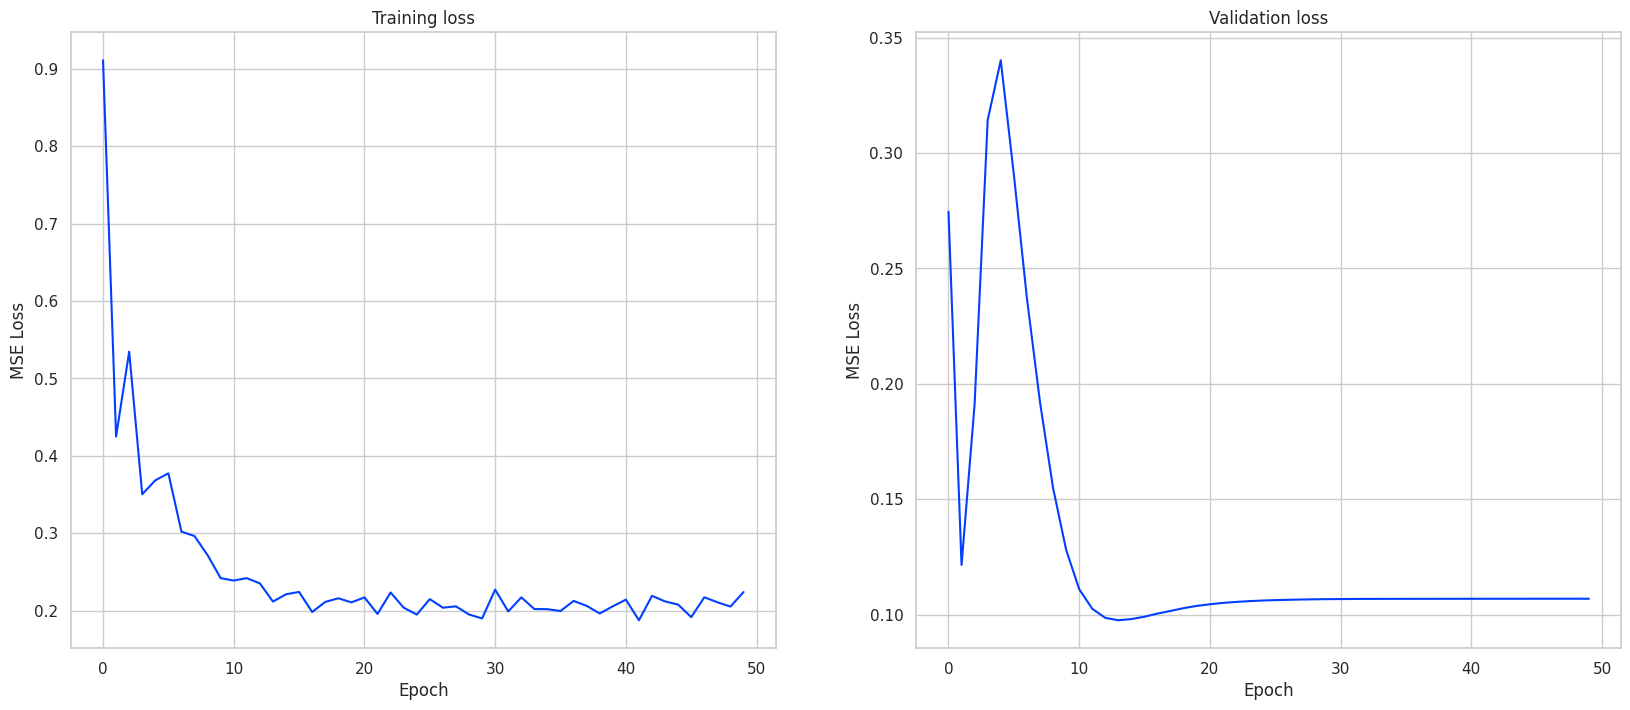

In [85]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")

In [86]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_test_metrics = get_metrics(prediction,true_labels)
baseline_test_metrics

Train:   0%|          | 0/4 [00:00<?, ?it/s]

(86,) (86,)


MSE      RMSE       MAE     MAPE  Serial Corr  Pearson Corr(IC),
0  40.676991  6.377852  4.754502  0.10271     0.801189          -0.043185

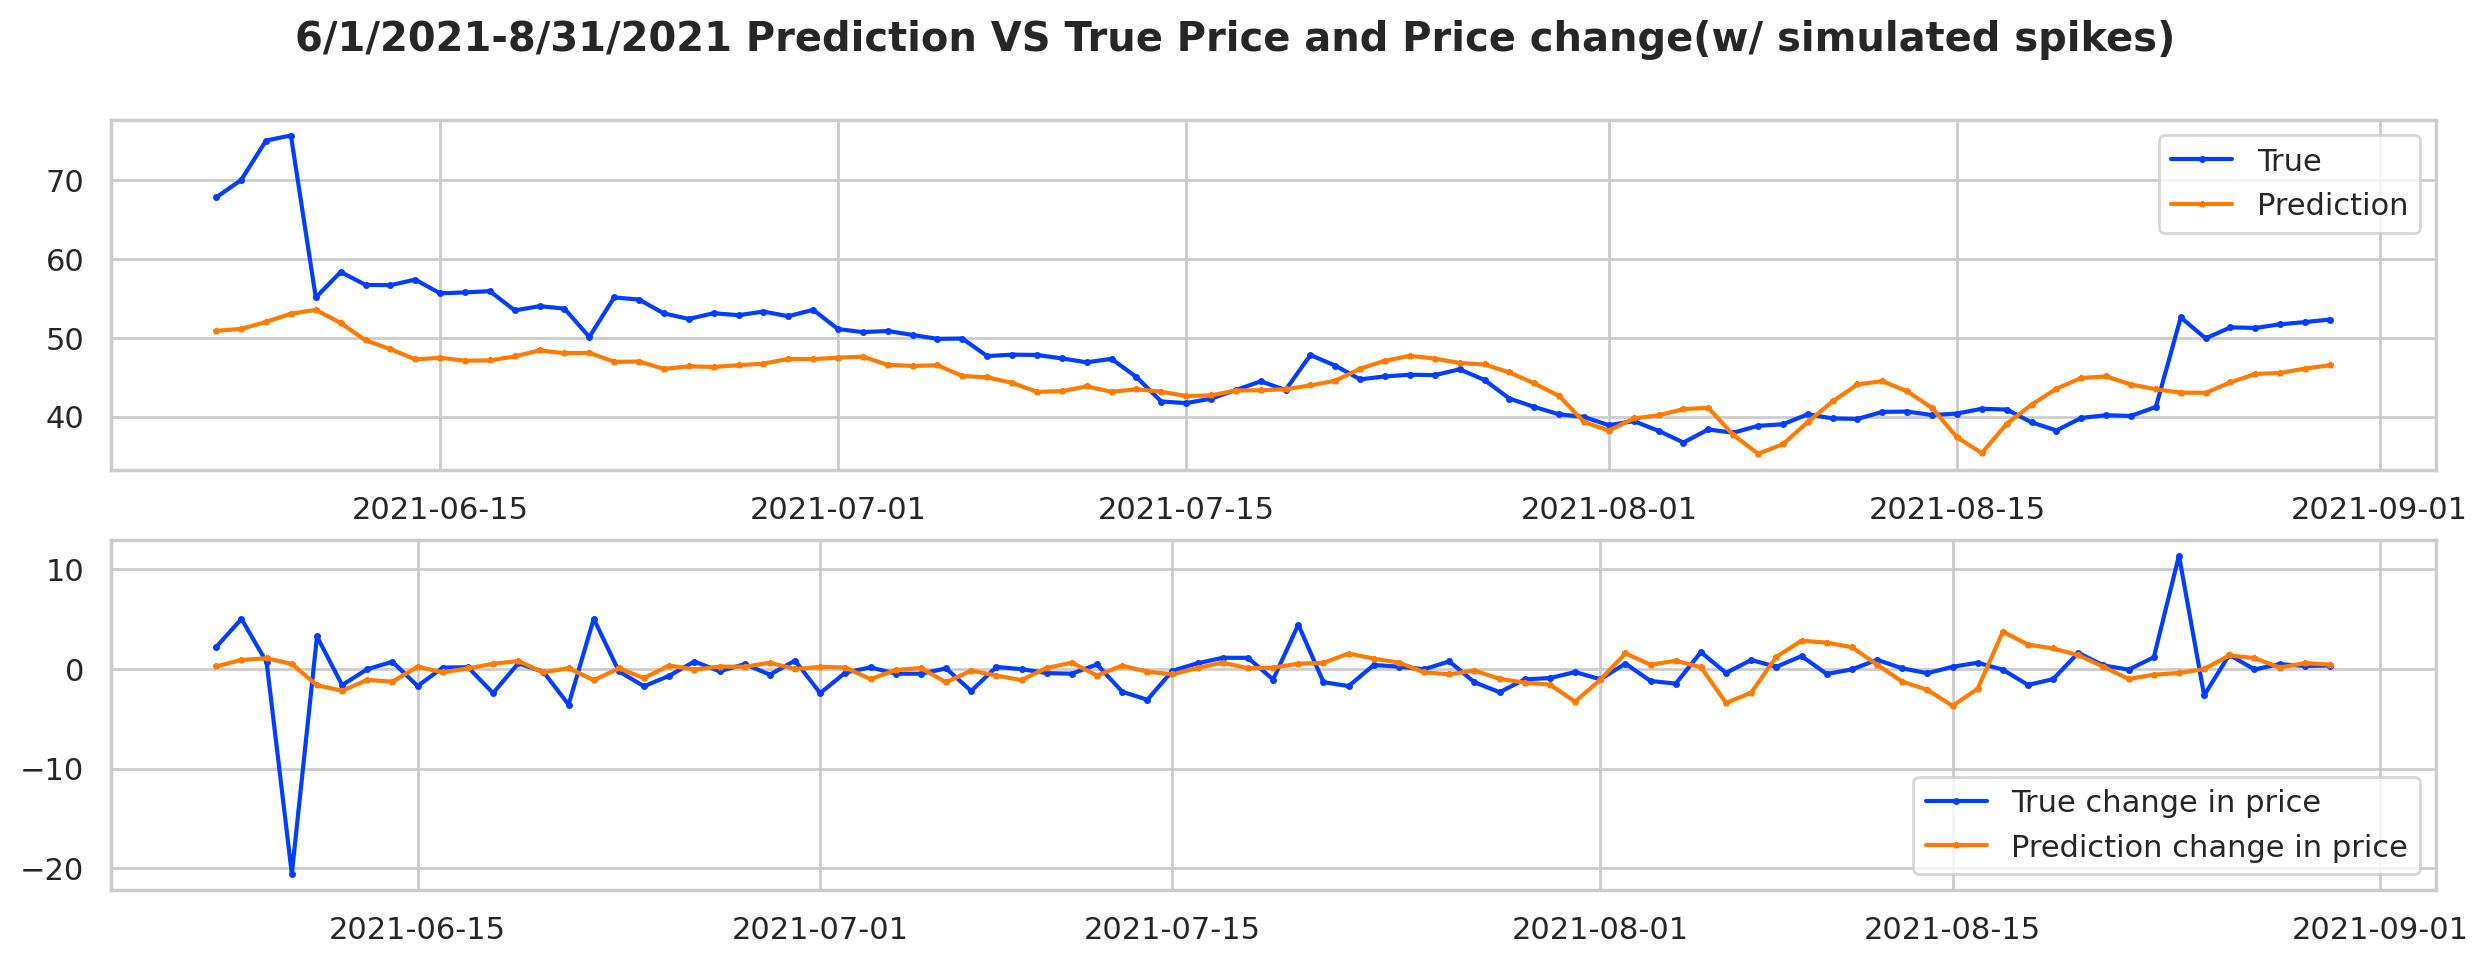

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming true_labels and prediction are numpy arrays or lists containing the true and predicted values.

# Filter the dataframe for the date range you're interested in and get the index as a datetime format
filtered_df = df_sa.loc[pd.to_datetime("2021-06-06"):pd.to_datetime("2021-08-30")]
date = filtered_df.index  # This should give you the date index directly

fig, ax = plt.subplots(2, 1, figsize=(15, 5), dpi=200)
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction', marker='*', markersize=2)
ax[0].legend()

# For the difference/delta plots, make sure the arrays are the correct length
# If true_labels and prediction are one element longer than the date array after diff, you need to slice them
true_changes = np.diff(true_labels)
pred_changes = np.diff(prediction)

# Ensure the lengths of date[1:], true_changes, and pred_changes are all equal
ax[1].plot(date[1:], true_changes, label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], pred_changes, label='Prediction change in price', marker='*', markersize=2)
ax[1].legend()

fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(w/ simulated spikes)", fontweight="bold")
plt.show()


In [88]:
# Create DataFrames from the dictionaries
data_simulated = baseline_test_metrics
data_actual = metrics2

# Concatenate the three DataFrames into a single DataFrame
df_combined = pd.concat([data_simulated, data_actual], ignore_index=True)

model_names = ['LSTM w/ Simulated Sentiment', 'LSTM w/ Actual Sentiment']
df_combined['Model'] = model_names

# Reorder columns to have 'Model' as the first column
df_combined = df_combined[['Model'] + [col for col in df_combined.columns if col != 'Model']]

df_combined

Model        MSE      RMSE       MAE      MAPE  \
0  LSTM w/ Simulated Sentiment  40.676991  6.377852  4.754502  0.102710   
1     LSTM w/ Actual Sentiment  39.280870  6.267445  4.578821  0.100428   

   Serial Corr  Pearson Corr(IC),  
0     0.801189          -0.043185  
1     0.901470          -0.121830

I tried a significant alteration—replacing half of the test data to randomly assign artificial sentiment spikes—to simulate a scenario of high volatility and sudden sentiment shifts.

The model with actual sentiment achieves slightly better performance across all error metrics (MSE, RMSE, MAE, MAPE) and has a higher serial correlation, indicating it captures the general trend of sentiment more accurately than the model with simulated spikes. This suggests that the model is more attuned to gradual shifts in sentiment rather than abrupt, spike-like changes. The presence of such spikes, akin to those during the GameStop saga, could be triggered by various factors including market manipulation, viral news, or significant investor actions, which the current model may not be capturing effectively.

To better identify these spikes and their impact on stock prices, if I had more time with this task, I would try another feature engineering approach that includes indicators for potential volatility and sudden sentiment changes may be required. This could involve incorporating measures like standard deviation of sentiment over a rolling window or a count of extreme sentiment values beyond certain thresholds. Additionally, implementing anomaly detection algorithms could help flag these spikes for a closer review.

### **Algorithm Adjustment**

If I had more time, would try:

1. Training the model on a dataset that includes more instances of such spikes to better learn the patterns associated with them.
2. Incorporating additional features that capture rapid changes in sentiment, such as the rate of change of sentiment or volatility indices.
3. Using ensemble methods that combine the predictions of models trained on stable periods with those trained specifically on volatile periods to enhance overall predictive performance.

## **Conclusion and Future Directions**

### **Summarization**

The sensitivity analysis of the LSTM models—one with actual sentiment data and the other with simulated sentiment spikes—highlights the current model's preference for more gradual shifts in sentiment. The model with actual sentiment demonstrates superior accuracy across standard error metrics (MSE, RMSE, MAE, MAPE) and a higher serial correlation, suggesting a reliable performance in capturing general sentiment trends. However, the model's limited response to simulated sentiment spikes, designed to mimic the volatility seen during events like the GameStop short squeeze, exposes its limitations in handling sudden and drastic shifts in public sentiment.

### **Discussion**

The GameStop short squeeze underscores the growing impact of collective social media activity on financial markets, challenging the effectiveness of traditional forecasting models. This event has amplified the conversation around the integration of social media sentiment data into predictive models. While this integration can provide a more nuanced understanding of market dynamics, it also raises ethical questions regarding data privacy, consent, and the potential for manipulation. Social media mining must be approached with caution, considering the authenticity of the data, the representativeness of sentiment, and the potential for echo chambers that may not accurately reflect wider market sentiments.



### **Proposal**

Future research should focus on developing more sophisticated models that can adapt to the high volatility and rapid shifts in sentiment evidenced on social media platforms. This could involve the use of advanced machine learning techniques that factor in anomaly detection and non-linear dependencies. Research could also explore the ethical boundaries of social media mining, establishing guidelines to ensure that data collection respects user privacy and consent. Another promising direction is the investigation of causality between social media sentiment and market movements, which could lead to a deeper understanding of the mechanisms at play. Moreover, the development of models that can discern genuine market sentiment from coordinated manipulation attempts would be invaluable in maintaining market integrity.






## **Reference**

1. Code from previous course: Unstructed Data Analytics (95865)
2. Code from previous course: Intro to Machine Learning (10601)
3. Code from 94812's ungraded assignments and recitation notebooks